# Find Your Ks
## Automated Kinetic Constant Extraction from Experimental Data ##
This notebook fits kinetic models to experimental time-series data to study reactions like asparagine deamidation. It generates random combinations of rate constant, resolve the kinetic scheme with each combination and calculate the RMSE between computed concentrations vs time and experimental concentration. The combinations providing an RMSE lower than a user-selected cutoff, are then optimized to fit the experimental data. The best optimized rate constants, filters by RMSE, are then utilized to estimate single-step free energy of activation. 

**Author**: De Sciscio Maria Laura · **Year**: 2025

---
To run this notebook with your own data, update the reaction system with the differential equations describing your kinetic scheme and add the required info in the cell below "Inputs and Options".

## Example for Deamidation

\[
$\text{Asn} \xrightarrow{K} \text{Asn}^- 
\rightleftharpoons^{k_{-1}}_{k_1} \text{Tet}^- 
\xrightarrow{k_2} \text{Suc} + \text{NH}_2^- 
\xrightarrow{k_3} \text{Asp} + \text{isoAsp}$
\]

**Species mapping to code:**
- \( $\text{Asn} = A $\)
- \( $\text{Tet}^- = B $\)
- \( $\text{Suc} = C $\)
- \( $\text{Asp} + \text{isoAsp} = D $\)

**Notes:**
- \( K \) is the ratio [Asn$^-$]/[Asn] 
- \( $k_1$, $k_{-1}$, $k_2$, $k_3$ \) are kinetic rate constants

### Kinetic constants obtained using the theoretical constants (from MD-PMM):

|              | Calc (s$^{-1}$) | NMR pH 8 (s$^{-1}$) | NMR pH 6 (s$^{-1}$) |
|--------------|-------------------|-----------------------|-----------------------|
| **K**        | 10$^{-1.38}$    | (10$^{-1.28}$\)        | 10$^{-3.36}$        |
| **pKa**      | 9.38              | 9.28                  | 9.36                  |
| **k$_1$**  | 3.75$ \cdot 10$ | (4.80$ \cdot 10$)     | 4.52$ \cdot 10$     |
| **k$_{-1}$** | 9.19 $\cdot 10^{6}$ | 6.11 $\cdot 10^{6}$ | 3.32 $\cdot 10^{6}$ |
| **k$_2$**  | 6.70              | 7.44                  | 9.85                  |
| **k$_3$**   | -                 | 5.51$ \cdot 10^{-5}$ | 1.14$ \cdot 10^{-6}$ |


In [1]:
def reaction_system(t, y, K, k1, k_1, k2, k3): #change the kinetic constants according to your kinetic scheme
    A, B, C, D = y
    dAdt = -k1 * K * A + k_1 * B
    dBdt = k1 * K * A - B * k2 - k_1 * B
    dCdt = B * k2 - C * k3
    dDdt = k3 * C
    return [dAdt, dBdt, dCdt, dDdt]

def fun(t,y):
    A, B, C, D = y
    dAdt = -k1 * K * A + k_1 * B
    dBdt = k1 * K * A - B * k2 - k_1 * B
    dCdt = B * k2 - C * k3
    dDdt = k3 * C
    return [dAdt, dBdt, dCdt, dDdt]

## Inputs and Options ##

In [2]:
#required inputs:
exp_file_path = 'formatted_data_pH8.csv' #should be normalized between 0 and 1

n_values = 20 #number of random values assigned to each k
minx = 0.00001 #bottom limit of the float range
maxx = 100000 #upper limit of the range
nk =  3 #number of kinetic constant to calculate
rmse_error = 3 #threshold rmse value. Combination of ks under this float will be optimized
output_suffix='random_fix_K_k4' #file name for saving ks combinations and corresponding error
T = 300 #temperature in Kelvin to estimate free energy barrier

In [3]:
import numpy as np
import os
import random
from matplotlib.gridspec import GridSpec
import itertools
import sys
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import glob
import pandas as pd
import signal
from scipy.integrate import solve_ivp
from kinetics import calc_dg, plot_solution_residuals

/home/mlds/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def gen_random(n_values, minx, maxx, nk):
    #n number of random values assigned to each k
    #nk number of constant to calculate
    #bottom limit of the range
    #upper limit of the range
    random_float_list = []
    for i in range(0, n_values//2):
        #use this section to ensure n values of random nuumber minor and lower than 1
        x = random.uniform(minx, 1) # any random float between minx to 1
        y = random.uniform(1.1, maxx) # any random float between 1.1 to maxx
        random_float_list.append(x)
        random_float_list.append(y)
        
        #random_float_list.append(random.uniform(minx, maxx)) #if you use the section above please comment thiis line
    combinations = list(itertools.product(random_float_list, repeat=nk)) #creates combinations of the random generated ks.
    return combinations


In [5]:
class TimeoutException(Exception):
    pass

# Handler to raise the timeout exception
def timeout_handler(signum, frame):
    raise TimeoutException

def calc_k(dA):
    k = (kb*T/h)* np.exp(-dA/(R*T))
    return k
 
def calc_error(y, list_of_exp_values):
    error = [np.sum((y_i - exp_i)**2) for y_i, exp_i in zip(y, list_of_exp_values)]
    return sum(error)

def objective_function(params, t, A, C, D, E):
    K, k2, k_2, k3, k4 = params
    y0 = [A[0], C[0], D[0], E[0]]  # Initial conditions
    #try:
    sol = solve_ivp(reaction_system, [t[0], t[-1]], y0, t_eval=t, args=(K, k2, k_2, k3, k4), method='LSODA' )
   
    A_model, C_model, D_model, E_model = sol.y
    
    error = (np.sum((A - A_model) ** 2) +
             np.sum((C - C_model) ** 2) +
             np.sum((D - D_model) ** 2) +
             np.sum((E - E_model) ** 2))
    return error


In [6]:
K = 10**(-0.1)
k3 = 10**(-5)

In [7]:
exp_data = np.loadtxt(exp_file_path, delimiter=',')
exp_data


array([[0.00000e+00, 9.90000e-01, 1.00000e-05, 1.00000e-02, 0.00000e+00],
       [2.57040e+04, 9.40000e-01, 1.00000e-05, 3.00000e-02, 3.00000e-02],
       [1.12608e+05, 7.80200e-01, 1.00000e-05, 3.80000e-02, 1.80000e-01],
       [1.46880e+05, 7.25000e-01, 1.00000e-05, 3.50000e-02, 2.40000e-01],
       [2.44800e+05, 6.40000e-01, 1.00000e-05, 3.00000e-02, 3.30000e-01],
       [2.75400e+05, 5.70000e-01, 1.00000e-05, 3.00000e-02, 4.00000e-01],
       [3.57408e+05, 5.00000e-01, 1.00000e-05, 2.50000e-02, 4.75000e-01],
       [3.97800e+05, 4.17000e-01, 1.00000e-05, 2.30000e-02, 5.70000e-01],
       [5.20200e+05, 3.22000e-01, 1.00000e-05, 1.60000e-02, 6.62000e-01],
       [6.42600e+05, 2.67000e-01, 1.00000e-05, 1.30000e-02, 7.20000e-01],
       [6.63408e+05, 2.17000e-01, 1.00000e-05, 1.30000e-02, 7.70000e-01],
       [8.56800e+05, 1.60000e-01, 1.00000e-05, 1.00000e-02, 8.30000e-01],
       [8.97192e+05, 1.16000e-01, 1.00000e-05, 8.00000e-03, 8.76000e-01],
       [9.74304e+05, 1.00000e-01, 1.00

In [8]:
combinations = gen_random(n_values, minx, maxx, nk)
initial_values = [y for y in exp_data[0,1:]]
t = exp_data[:,0]*(60*60*24)
interval = [0, t[-1]]
idx = 0
errors, params_list=[],[]
with open(f'error_ks_{len(combinations)}_{output_suffix}', 'w') as out:
    out.write(f'K,k1,k_1,k2,k3,RMSE\n')
    for comb in combinations:
        k1,k_1,k2 = comb
        print(f'K={K}, k1={k1}, k_1={k_1}, k2={k2}, k3={k3}')
        try:
            solution = solve_ivp(fun, interval,t_eval=t,y0=initial_values,method='LSODA')#,  dense_output=True, , t_eval=t_eval)
            error = calc_error(solution.y, exp_data[:,1:].T)
            print(error)
        except Exception as e:
            print(f"Error with params K={K}, k1={k1}, k_1={k_1}, k2={k2}, k3={k3}: {e}")
            error = np.inf  # Assign a high error value if the solver fails
        params_list.append(comb)
        errors.append(error)
        out.write(f'{K},{k1},{k_1},{k2},{k3},{error}\n')


K=0.7943282347242815, k1=0.01338177278405689, k_1=0.01338177278405689, k2=0.01338177278405689, k3=1e-05
7.216718541940947
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.01338177278405689, k2=10497.519686434585, k3=1e-05
7.216718542576358
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.01338177278405689, k2=0.29484943266285873, k3=1e-05
7.216718542704838
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.01338177278405689, k2=21695.741088331954, k3=1e-05
7.216718542577076
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.01338177278405689, k2=0.23379795489172275, k3=1e-05
7.216718542574204
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.01338177278405689, k2=12883.117635954884, k3=1e-05
7.216718542654451
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.01338177278405689, k2=0.23039648062977286, k3=1e-05
7.216718542443601
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.01338177278405689, k2=23706.87447452002, k3=1e-05
7.216718542581038
K=0.7943282347242815, k1=0.01

7.216718542570277
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.23379795489172275, k2=0.7136170765521401, k3=1e-05
7.21671854257426
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.23379795489172275, k2=37853.997933576626, k3=1e-05
7.2167185425983025
K=0.7943282347242815, k1=0.01338177278405689, k_1=12883.117635954884, k2=0.01338177278405689, k3=1e-05
7.216721401905351
K=0.7943282347242815, k1=0.01338177278405689, k_1=12883.117635954884, k2=10497.519686434585, k3=1e-05
7.216718542500238
K=0.7943282347242815, k1=0.01338177278405689, k_1=12883.117635954884, k2=0.29484943266285873, k3=1e-05
7.216718482218116
K=0.7943282347242815, k1=0.01338177278405689, k_1=12883.117635954884, k2=21695.741088331954, k3=1e-05
7.216718542616626
K=0.7943282347242815, k1=0.01338177278405689, k_1=12883.117635954884, k2=0.23379795489172275, k3=1e-05
7.216718685620099
K=0.7943282347242815, k1=0.01338177278405689, k_1=12883.117635954884, k2=12883.117635954884, k3=1e-05
7.216718542619981
K=0.7943282347242

7.216718542563154
K=0.7943282347242815, k1=0.01338177278405689, k_1=17976.23151800441, k2=0.7136170765521401, k3=1e-05
7.2167185471857405
K=0.7943282347242815, k1=0.01338177278405689, k_1=17976.23151800441, k2=37853.997933576626, k3=1e-05
7.21671854256784
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.6337685914610052, k2=0.01338177278405689, k3=1e-05
7.216718528504524
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.6337685914610052, k2=10497.519686434585, k3=1e-05
7.216718542630167
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.6337685914610052, k2=0.29484943266285873, k3=1e-05
7.216718540536222
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.6337685914610052, k2=21695.741088331954, k3=1e-05
7.216718542645268
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.6337685914610052, k2=0.23379795489172275, k3=1e-05
7.216718542277267
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.6337685914610052, k2=12883.117635954884, k3=1e-05
7.216718542581004
K=0.7943282347242815,

7.216718541686031
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.03994709824090956, k2=85860.06796771534, k3=1e-05
7.21671854261797
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.03994709824090956, k2=0.8596181799854231, k3=1e-05
7.216718543631722
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.03994709824090956, k2=94878.7447254792, k3=1e-05
7.216718542616981
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.03994709824090956, k2=0.7136170765521401, k3=1e-05
7.216718542317354
K=0.7943282347242815, k1=0.01338177278405689, k_1=0.03994709824090956, k2=37853.997933576626, k3=1e-05
7.216718542643443
K=0.7943282347242815, k1=0.01338177278405689, k_1=85860.06796771534, k2=0.01338177278405689, k3=1e-05
7.122683611720404
K=0.7943282347242815, k1=0.01338177278405689, k_1=85860.06796771534, k2=10497.519686434585, k3=1e-05
7.216718542565397
K=0.7943282347242815, k1=0.01338177278405689, k_1=85860.06796771534, k2=0.29484943266285873, k3=1e-05
7.216720455864836
K=0.7943282347242815, 

7.215808101148221
K=0.7943282347242815, k1=0.01338177278405689, k_1=37853.997933576626, k2=10497.519686434585, k3=1e-05
7.216718542493553
K=0.7943282347242815, k1=0.01338177278405689, k_1=37853.997933576626, k2=0.29484943266285873, k3=1e-05
7.216718697085652
K=0.7943282347242815, k1=0.01338177278405689, k_1=37853.997933576626, k2=21695.741088331954, k3=1e-05
7.216718542593047
K=0.7943282347242815, k1=0.01338177278405689, k_1=37853.997933576626, k2=0.23379795489172275, k3=1e-05
7.216722004632494
K=0.7943282347242815, k1=0.01338177278405689, k_1=37853.997933576626, k2=12883.117635954884, k3=1e-05
7.216718542728075
K=0.7943282347242815, k1=0.01338177278405689, k_1=37853.997933576626, k2=0.23039648062977286, k3=1e-05
7.2167250507111955
K=0.7943282347242815, k1=0.01338177278405689, k_1=37853.997933576626, k2=23706.87447452002, k3=1e-05
7.216718542586275
K=0.7943282347242815, k1=0.01338177278405689, k_1=37853.997933576626, k2=0.9290527806383222, k3=1e-05
7.216716843239274
K=0.794328234724281

7.216718611920334
K=0.7943282347242815, k1=10497.519686434585, k_1=21695.741088331954, k2=17976.23151800441, k3=1e-05
7.216718542599715
K=0.7943282347242815, k1=10497.519686434585, k_1=21695.741088331954, k2=0.6337685914610052, k3=1e-05
7.216720030786565
K=0.7943282347242815, k1=10497.519686434585, k_1=21695.741088331954, k2=13198.177178729722, k3=1e-05
7.2167185425783815
K=0.7943282347242815, k1=10497.519686434585, k_1=21695.741088331954, k2=0.6665526267879957, k3=1e-05
7.2167193880404685
K=0.7943282347242815, k1=10497.519686434585, k_1=21695.741088331954, k2=77458.35572914153, k3=1e-05
7.216718542618439
K=0.7943282347242815, k1=10497.519686434585, k_1=21695.741088331954, k2=0.03994709824090956, k3=1e-05
7.216653584263386
K=0.7943282347242815, k1=10497.519686434585, k_1=21695.741088331954, k2=85860.06796771534, k3=1e-05
7.216718542595293
K=0.7943282347242815, k1=10497.519686434585, k_1=21695.741088331954, k2=0.8596181799854231, k3=1e-05
7.216718758059313
K=0.7943282347242815, k1=10497

K=0.7943282347242815, k1=10497.519686434585, k_1=0.9290527806383222, k2=0.23039648062977286, k3=1e-05
7.216718542168183
K=0.7943282347242815, k1=10497.519686434585, k_1=0.9290527806383222, k2=23706.87447452002, k3=1e-05
7.216718542601569
K=0.7943282347242815, k1=10497.519686434585, k_1=0.9290527806383222, k2=0.9290527806383222, k3=1e-05
7.216718542583518
K=0.7943282347242815, k1=10497.519686434585, k_1=0.9290527806383222, k2=17976.23151800441, k3=1e-05
7.216718542600001
K=0.7943282347242815, k1=10497.519686434585, k_1=0.9290527806383222, k2=0.6337685914610052, k3=1e-05
7.216718542621045
K=0.7943282347242815, k1=10497.519686434585, k_1=0.9290527806383222, k2=13198.177178729722, k3=1e-05
7.216718542599962
K=0.7943282347242815, k1=10497.519686434585, k_1=0.9290527806383222, k2=0.6665526267879957, k3=1e-05
7.21671854267392
K=0.7943282347242815, k1=10497.519686434585, k_1=0.9290527806383222, k2=77458.35572914153, k3=1e-05
7.216718542600255
K=0.7943282347242815, k1=10497.519686434585, k_1=0.

7.216718542761436
K=0.7943282347242815, k1=10497.519686434585, k_1=77458.35572914153, k2=0.29484943266285873, k3=1e-05
7.216732486702666
K=0.7943282347242815, k1=10497.519686434585, k_1=77458.35572914153, k2=21695.741088331954, k3=1e-05
7.216718543138953
K=0.7943282347242815, k1=10497.519686434585, k_1=77458.35572914153, k2=0.23379795489172275, k3=1e-05
7.216715320897994
K=0.7943282347242815, k1=10497.519686434585, k_1=77458.35572914153, k2=12883.117635954884, k3=1e-05
7.216718542416812
K=0.7943282347242815, k1=10497.519686434585, k_1=77458.35572914153, k2=0.23039648062977286, k3=1e-05
7.2167227403121075
K=0.7943282347242815, k1=10497.519686434585, k_1=77458.35572914153, k2=23706.87447452002, k3=1e-05
7.2167185426672305
K=0.7943282347242815, k1=10497.519686434585, k_1=77458.35572914153, k2=0.9290527806383222, k3=1e-05
7.216715133023175
K=0.7943282347242815, k1=10497.519686434585, k_1=77458.35572914153, k2=17976.23151800441, k3=1e-05
7.216718542479947
K=0.7943282347242815, k1=10497.5196

7.2167127876954105
K=0.7943282347242815, k1=10497.519686434585, k_1=94878.7447254792, k2=17976.23151800441, k3=1e-05
7.216718542410803
K=0.7943282347242815, k1=10497.519686434585, k_1=94878.7447254792, k2=0.6337685914610052, k3=1e-05
7.216711084978163
K=0.7943282347242815, k1=10497.519686434585, k_1=94878.7447254792, k2=13198.177178729722, k3=1e-05
7.216718542608822
K=0.7943282347242815, k1=10497.519686434585, k_1=94878.7447254792, k2=0.6665526267879957, k3=1e-05
7.216714883903883
K=0.7943282347242815, k1=10497.519686434585, k_1=94878.7447254792, k2=77458.35572914153, k3=1e-05
7.2167185426648714
K=0.7943282347242815, k1=10497.519686434585, k_1=94878.7447254792, k2=0.03994709824090956, k3=1e-05
7.216779391506947
K=0.7943282347242815, k1=10497.519686434585, k_1=94878.7447254792, k2=85860.06796771534, k3=1e-05
7.216718542529839
K=0.7943282347242815, k1=10497.519686434585, k_1=94878.7447254792, k2=0.8596181799854231, k3=1e-05
7.216716411502361
K=0.7943282347242815, k1=10497.519686434585, k

7.216718542596434
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.29484943266285873, k2=77458.35572914153, k3=1e-05
7.216718542601379
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.29484943266285873, k2=0.03994709824090956, k3=1e-05
7.216718539759173
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.29484943266285873, k2=85860.06796771534, k3=1e-05
7.216718542615392
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.29484943266285873, k2=0.8596181799854231, k3=1e-05
7.2167185426331635
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.29484943266285873, k2=94878.7447254792, k3=1e-05
7.216718542615897
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.29484943266285873, k2=0.7136170765521401, k3=1e-05
7.2167185426842
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.29484943266285873, k2=37853.997933576626, k3=1e-05
7.21671854255956
K=0.7943282347242815, k1=0.29484943266285873, k_1=21695.741088331954, k2=0.01338177278405689, k3=1e-05
7.216637031204156
K=0.794328234724281

7.2167185425591995
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.23039648062977286, k2=23706.87447452002, k3=1e-05
7.216718542569373
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.23039648062977286, k2=0.9290527806383222, k3=1e-05
7.21671854260082
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.23039648062977286, k2=17976.23151800441, k3=1e-05
7.216718542596649
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.23039648062977286, k2=0.6337685914610052, k3=1e-05
7.216718542614782
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.23039648062977286, k2=13198.177178729722, k3=1e-05
7.216718542594695
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.23039648062977286, k2=0.6665526267879957, k3=1e-05
7.216718542587499
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.23039648062977286, k2=77458.35572914153, k3=1e-05
7.2167185425307165
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.23039648062977286, k2=0.03994709824090956, k3=1e-05
7.2167185418724475
K=0.7943282347

7.2167185425537035
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.6337685914610052, k2=0.29484943266285873, k3=1e-05
7.216718542743568
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.6337685914610052, k2=21695.741088331954, k3=1e-05
7.216718542600903
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.6337685914610052, k2=0.23379795489172275, k3=1e-05
7.216718542588407
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.6337685914610052, k2=12883.117635954884, k3=1e-05
7.2167185425869
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.6337685914610052, k2=0.23039648062977286, k3=1e-05
7.216718543113558
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.6337685914610052, k2=23706.87447452002, k3=1e-05
7.216718542545285
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.6337685914610052, k2=0.9290527806383222, k3=1e-05
7.216718541606553
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.6337685914610052, k2=17976.23151800441, k3=1e-05
7.216718542594361
K=0.7943282347242815, 

7.216718542608686
K=0.7943282347242815, k1=0.29484943266285873, k_1=77458.35572914153, k2=0.8596181799854231, k3=1e-05
7.216718459455446
K=0.7943282347242815, k1=0.29484943266285873, k_1=77458.35572914153, k2=94878.7447254792, k3=1e-05
7.216718542652533
K=0.7943282347242815, k1=0.29484943266285873, k_1=77458.35572914153, k2=0.7136170765521401, k3=1e-05
7.216716696540312
K=0.7943282347242815, k1=0.29484943266285873, k_1=77458.35572914153, k2=37853.997933576626, k3=1e-05
7.2167185426360785
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.03994709824090956, k2=0.01338177278405689, k3=1e-05
7.216718540206102
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.03994709824090956, k2=10497.519686434585, k3=1e-05
7.216718542574515
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.03994709824090956, k2=0.29484943266285873, k3=1e-05
7.216718542707136
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.03994709824090956, k2=21695.741088331954, k3=1e-05
7.216718542625564
K=0.7943282347242815,

7.2167185455299805
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.7136170765521401, k2=10497.519686434585, k3=1e-05
7.216718542573145
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.7136170765521401, k2=0.29484943266285873, k3=1e-05
7.216718542538115
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.7136170765521401, k2=21695.741088331954, k3=1e-05
7.216718542641841
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.7136170765521401, k2=0.23379795489172275, k3=1e-05
7.216718542186028
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.7136170765521401, k2=12883.117635954884, k3=1e-05
7.216718542675592
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.7136170765521401, k2=0.23039648062977286, k3=1e-05
7.2167185418558075
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.7136170765521401, k2=23706.87447452002, k3=1e-05
7.216718542523026
K=0.7943282347242815, k1=0.29484943266285873, k_1=0.7136170765521401, k2=0.9290527806383222, k3=1e-05
7.216718543299077
K=0.79432823472428

7.216718542701708
K=0.7943282347242815, k1=21695.741088331954, k_1=0.29484943266285873, k2=13198.177178729722, k3=1e-05
7.216718542600017
K=0.7943282347242815, k1=21695.741088331954, k_1=0.29484943266285873, k2=0.6665526267879957, k3=1e-05
7.216718542589454
K=0.7943282347242815, k1=21695.741088331954, k_1=0.29484943266285873, k2=77458.35572914153, k3=1e-05
7.216718542599462
K=0.7943282347242815, k1=21695.741088331954, k_1=0.29484943266285873, k2=0.03994709824090956, k3=1e-05
7.216718541072936
K=0.7943282347242815, k1=21695.741088331954, k_1=0.29484943266285873, k2=85860.06796771534, k3=1e-05
7.216718542600145
K=0.7943282347242815, k1=21695.741088331954, k_1=0.29484943266285873, k2=0.8596181799854231, k3=1e-05
7.216718542527465
K=0.7943282347242815, k1=21695.741088331954, k_1=0.29484943266285873, k2=94878.7447254792, k3=1e-05
7.216718542599805
K=0.7943282347242815, k1=21695.741088331954, k_1=0.29484943266285873, k2=0.7136170765521401, k3=1e-05
7.216718542565447
K=0.7943282347242815, k1=

7.216718542655704
K=0.7943282347242815, k1=21695.741088331954, k_1=0.23039648062977286, k2=13198.177178729722, k3=1e-05
7.216718542599752
K=0.7943282347242815, k1=21695.741088331954, k_1=0.23039648062977286, k2=0.6665526267879957, k3=1e-05
7.21671854260109
K=0.7943282347242815, k1=21695.741088331954, k_1=0.23039648062977286, k2=77458.35572914153, k3=1e-05
7.216718542600455
K=0.7943282347242815, k1=21695.741088331954, k_1=0.23039648062977286, k2=0.03994709824090956, k3=1e-05
7.216718542978441
K=0.7943282347242815, k1=21695.741088331954, k_1=0.23039648062977286, k2=85860.06796771534, k3=1e-05
7.216718542599931
K=0.7943282347242815, k1=21695.741088331954, k_1=0.23039648062977286, k2=0.8596181799854231, k3=1e-05
7.216718542549171
K=0.7943282347242815, k1=21695.741088331954, k_1=0.23039648062977286, k2=94878.7447254792, k3=1e-05
7.2167185426000575
K=0.7943282347242815, k1=21695.741088331954, k_1=0.23039648062977286, k2=0.7136170765521401, k3=1e-05
7.216718542712279
K=0.7943282347242815, k1=

7.216718541713016
K=0.7943282347242815, k1=21695.741088331954, k_1=0.6337685914610052, k2=10497.519686434585, k3=1e-05
7.216718542599875
K=0.7943282347242815, k1=21695.741088331954, k_1=0.6337685914610052, k2=0.29484943266285873, k3=1e-05
7.216718542816585
K=0.7943282347242815, k1=21695.741088331954, k_1=0.6337685914610052, k2=21695.741088331954, k3=1e-05
7.2167185426003115
K=0.7943282347242815, k1=21695.741088331954, k_1=0.6337685914610052, k2=0.23379795489172275, k3=1e-05
7.216718542803148
K=0.7943282347242815, k1=21695.741088331954, k_1=0.6337685914610052, k2=12883.117635954884, k3=1e-05
7.216718542600249
K=0.7943282347242815, k1=21695.741088331954, k_1=0.6337685914610052, k2=0.23039648062977286, k3=1e-05
7.21671854250439
K=0.7943282347242815, k1=21695.741088331954, k_1=0.6337685914610052, k2=23706.87447452002, k3=1e-05
7.216718542599805
K=0.7943282347242815, k1=21695.741088331954, k_1=0.6337685914610052, k2=0.9290527806383222, k3=1e-05
7.216718542725756
K=0.7943282347242815, k1=216

7.216718542599404
K=0.7943282347242815, k1=21695.741088331954, k_1=0.03994709824090956, k2=0.9290527806383222, k3=1e-05
7.21671854252738
K=0.7943282347242815, k1=21695.741088331954, k_1=0.03994709824090956, k2=17976.23151800441, k3=1e-05
7.216718542600242
K=0.7943282347242815, k1=21695.741088331954, k_1=0.03994709824090956, k2=0.6337685914610052, k3=1e-05
7.216718542524921
K=0.7943282347242815, k1=21695.741088331954, k_1=0.03994709824090956, k2=13198.177178729722, k3=1e-05
7.216718542600078
K=0.7943282347242815, k1=21695.741088331954, k_1=0.03994709824090956, k2=0.6665526267879957, k3=1e-05
7.216718542682367
K=0.7943282347242815, k1=21695.741088331954, k_1=0.03994709824090956, k2=77458.35572914153, k3=1e-05
7.216718542601213
K=0.7943282347242815, k1=21695.741088331954, k_1=0.03994709824090956, k2=0.03994709824090956, k3=1e-05
7.216718539929025
K=0.7943282347242815, k1=21695.741088331954, k_1=0.03994709824090956, k2=85860.06796771534, k3=1e-05
7.2167185426001215
K=0.7943282347242815, k1

7.216718542599671
K=0.7943282347242815, k1=21695.741088331954, k_1=0.7136170765521401, k2=0.9290527806383222, k3=1e-05
7.216718542680692
K=0.7943282347242815, k1=21695.741088331954, k_1=0.7136170765521401, k2=17976.23151800441, k3=1e-05
7.216718542599671
K=0.7943282347242815, k1=21695.741088331954, k_1=0.7136170765521401, k2=0.6337685914610052, k3=1e-05
7.216718542578942
K=0.7943282347242815, k1=21695.741088331954, k_1=0.7136170765521401, k2=13198.177178729722, k3=1e-05
7.216718542600169
K=0.7943282347242815, k1=21695.741088331954, k_1=0.7136170765521401, k2=0.6665526267879957, k3=1e-05
7.21671854259562
K=0.7943282347242815, k1=21695.741088331954, k_1=0.7136170765521401, k2=77458.35572914153, k3=1e-05
7.216718542600439
K=0.7943282347242815, k1=21695.741088331954, k_1=0.7136170765521401, k2=0.03994709824090956, k3=1e-05
7.216718544233441
K=0.7943282347242815, k1=21695.741088331954, k_1=0.7136170765521401, k2=85860.06796771534, k3=1e-05
7.216718542600196
K=0.7943282347242815, k1=21695.74

7.216718542651473
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.29484943266285873, k2=0.8596181799854231, k3=1e-05
7.216718542578633
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.29484943266285873, k2=94878.7447254792, k3=1e-05
7.216718542521785
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.29484943266285873, k2=0.7136170765521401, k3=1e-05
7.216718542593443
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.29484943266285873, k2=37853.997933576626, k3=1e-05
7.21671854262028
K=0.7943282347242815, k1=0.23379795489172275, k_1=21695.741088331954, k2=0.01338177278405689, k3=1e-05
7.216843142032136
K=0.7943282347242815, k1=0.23379795489172275, k_1=21695.741088331954, k2=10497.519686434585, k3=1e-05
7.216718542470109
K=0.7943282347242815, k1=0.23379795489172275, k_1=21695.741088331954, k2=0.29484943266285873, k3=1e-05
7.216718180996206
K=0.7943282347242815, k1=0.23379795489172275, k_1=21695.741088331954, k2=21695.741088331954, k3=1e-05
7.216718542588538
K=0.794328234724281

7.216718542503257
K=0.7943282347242815, k1=0.23379795489172275, k_1=23706.87447452002, k2=0.6665526267879957, k3=1e-05
7.216718575177923
K=0.7943282347242815, k1=0.23379795489172275, k_1=23706.87447452002, k2=77458.35572914153, k3=1e-05
7.2167185425784455
K=0.7943282347242815, k1=0.23379795489172275, k_1=23706.87447452002, k2=0.03994709824090956, k3=1e-05
7.216714704672099
K=0.7943282347242815, k1=0.23379795489172275, k_1=23706.87447452002, k2=85860.06796771534, k3=1e-05
7.216718542559358
K=0.7943282347242815, k1=0.23379795489172275, k_1=23706.87447452002, k2=0.8596181799854231, k3=1e-05
7.2167185884445875
K=0.7943282347242815, k1=0.23379795489172275, k_1=23706.87447452002, k2=94878.7447254792, k3=1e-05
7.216718542480317
K=0.7943282347242815, k1=0.23379795489172275, k_1=23706.87447452002, k2=0.7136170765521401, k3=1e-05
7.216718550634921
K=0.7943282347242815, k1=0.23379795489172275, k_1=23706.87447452002, k2=37853.997933576626, k3=1e-05
7.21671854256164
K=0.7943282347242815, k1=0.23379

7.2167185426192635
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.6665526267879957, k2=0.6665526267879957, k3=1e-05
7.2167185422212805
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.6665526267879957, k2=77458.35572914153, k3=1e-05
7.216718542601743
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.6665526267879957, k2=0.03994709824090956, k3=1e-05
7.21671854154461
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.6665526267879957, k2=85860.06796771534, k3=1e-05
7.2167185426232745
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.6665526267879957, k2=0.8596181799854231, k3=1e-05
7.21671854236385
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.6665526267879957, k2=94878.7447254792, k3=1e-05
7.2167185426259906
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.6665526267879957, k2=0.7136170765521401, k3=1e-05
7.216718543227252
K=0.7943282347242815, k1=0.23379795489172275, k_1=0.6665526267879957, k2=37853.997933576626, k3=1e-05
7.216718542630881
K=0.7943282347242815, k

7.216718488588881
K=0.7943282347242815, k1=0.23379795489172275, k_1=94878.7447254792, k2=17976.23151800441, k3=1e-05
7.216718542810655
K=0.7943282347242815, k1=0.23379795489172275, k_1=94878.7447254792, k2=0.6337685914610052, k3=1e-05
7.21672243898924
K=0.7943282347242815, k1=0.23379795489172275, k_1=94878.7447254792, k2=13198.177178729722, k3=1e-05
7.216718542506044
K=0.7943282347242815, k1=0.23379795489172275, k_1=94878.7447254792, k2=0.6665526267879957, k3=1e-05
7.216719205510488
K=0.7943282347242815, k1=0.23379795489172275, k_1=94878.7447254792, k2=77458.35572914153, k3=1e-05
7.21671854242636
K=0.7943282347242815, k1=0.23379795489172275, k_1=94878.7447254792, k2=0.03994709824090956, k3=1e-05
7.216731526732321
K=0.7943282347242815, k1=0.23379795489172275, k_1=94878.7447254792, k2=85860.06796771534, k3=1e-05
7.216718542577263
K=0.7943282347242815, k1=0.23379795489172275, k_1=94878.7447254792, k2=0.8596181799854231, k3=1e-05
7.216717444928724
K=0.7943282347242815, k1=0.233797954891722

7.216718542599946
K=0.7943282347242815, k1=12883.117635954884, k_1=0.29484943266285873, k2=0.01338177278405689, k3=1e-05
7.2167185256627775
K=0.7943282347242815, k1=12883.117635954884, k_1=0.29484943266285873, k2=10497.519686434585, k3=1e-05
7.2167185426001375
K=0.7943282347242815, k1=12883.117635954884, k_1=0.29484943266285873, k2=0.29484943266285873, k3=1e-05
7.216718542726978
K=0.7943282347242815, k1=12883.117635954884, k_1=0.29484943266285873, k2=21695.741088331954, k3=1e-05
7.216718542600374
K=0.7943282347242815, k1=12883.117635954884, k_1=0.29484943266285873, k2=0.23379795489172275, k3=1e-05
7.216718542763866
K=0.7943282347242815, k1=12883.117635954884, k_1=0.29484943266285873, k2=12883.117635954884, k3=1e-05
7.216718542600389
K=0.7943282347242815, k1=12883.117635954884, k_1=0.29484943266285873, k2=0.23039648062977286, k3=1e-05
7.2167185425249905
K=0.7943282347242815, k1=12883.117635954884, k_1=0.29484943266285873, k2=23706.87447452002, k3=1e-05
7.216718542600271
K=0.794328234724

7.216718827269829
K=0.7943282347242815, k1=12883.117635954884, k_1=12883.117635954884, k2=13198.177178729722, k3=1e-05
7.216718542599994
K=0.7943282347242815, k1=12883.117635954884, k_1=12883.117635954884, k2=0.6665526267879957, k3=1e-05
7.216718884886463
K=0.7943282347242815, k1=12883.117635954884, k_1=12883.117635954884, k2=77458.35572914153, k3=1e-05
7.216718542599901
K=0.7943282347242815, k1=12883.117635954884, k_1=12883.117635954884, k2=0.03994709824090956, k3=1e-05
7.216718545655102
K=0.7943282347242815, k1=12883.117635954884, k_1=12883.117635954884, k2=85860.06796771534, k3=1e-05
7.216718542604005
K=0.7943282347242815, k1=12883.117635954884, k_1=12883.117635954884, k2=0.8596181799854231, k3=1e-05
7.216718432786311
K=0.7943282347242815, k1=12883.117635954884, k_1=12883.117635954884, k2=94878.7447254792, k3=1e-05
7.216718542599857
K=0.7943282347242815, k1=12883.117635954884, k_1=12883.117635954884, k2=0.7136170765521401, k3=1e-05
7.216718624607797
K=0.7943282347242815, k1=12883.11

7.216722860617322
K=0.7943282347242815, k1=12883.117635954884, k_1=17976.23151800441, k2=10497.519686434585, k3=1e-05
7.2167185426005656
K=0.7943282347242815, k1=12883.117635954884, k_1=17976.23151800441, k2=0.29484943266285873, k3=1e-05
7.216717741464657
K=0.7943282347242815, k1=12883.117635954884, k_1=17976.23151800441, k2=21695.741088331954, k3=1e-05
7.216718542604188
K=0.7943282347242815, k1=12883.117635954884, k_1=17976.23151800441, k2=0.23379795489172275, k3=1e-05
7.216719579199973
K=0.7943282347242815, k1=12883.117635954884, k_1=17976.23151800441, k2=12883.117635954884, k3=1e-05
7.216718542600331
K=0.7943282347242815, k1=12883.117635954884, k_1=17976.23151800441, k2=0.23039648062977286, k3=1e-05
7.216717197982955
K=0.7943282347242815, k1=12883.117635954884, k_1=17976.23151800441, k2=23706.87447452002, k3=1e-05
7.216718542599725
K=0.7943282347242815, k1=12883.117635954884, k_1=17976.23151800441, k2=0.9290527806383222, k3=1e-05
7.21671860957699
K=0.7943282347242815, k1=12883.11763

7.21671854259907
K=0.7943282347242815, k1=12883.117635954884, k_1=0.6665526267879957, k2=0.7136170765521401, k3=1e-05
7.216718542546359
K=0.7943282347242815, k1=12883.117635954884, k_1=0.6665526267879957, k2=37853.997933576626, k3=1e-05
7.216718542599637
K=0.7943282347242815, k1=12883.117635954884, k_1=77458.35572914153, k2=0.01338177278405689, k3=1e-05
7.216801219920247
K=0.7943282347242815, k1=12883.117635954884, k_1=77458.35572914153, k2=10497.519686434585, k3=1e-05
7.216718542758571
K=0.7943282347242815, k1=12883.117635954884, k_1=77458.35572914153, k2=0.29484943266285873, k3=1e-05
7.21671566766733
K=0.7943282347242815, k1=12883.117635954884, k_1=77458.35572914153, k2=21695.741088331954, k3=1e-05
7.216718542590435
K=0.7943282347242815, k1=12883.117635954884, k_1=77458.35572914153, k2=0.23379795489172275, k3=1e-05
7.2167135114496705
K=0.7943282347242815, k1=12883.117635954884, k_1=77458.35572914153, k2=12883.117635954884, k3=1e-05
7.21671854301556
K=0.7943282347242815, k1=12883.1176

7.216718542594219
K=0.7943282347242815, k1=12883.117635954884, k_1=0.8596181799854231, k2=37853.997933576626, k3=1e-05
7.216718542600732
K=0.7943282347242815, k1=12883.117635954884, k_1=94878.7447254792, k2=0.01338177278405689, k3=1e-05
7.216679673647447
K=0.7943282347242815, k1=12883.117635954884, k_1=94878.7447254792, k2=10497.519686434585, k3=1e-05
7.216718542546278
K=0.7943282347242815, k1=12883.117635954884, k_1=94878.7447254792, k2=0.29484943266285873, k3=1e-05
7.216706420643449
K=0.7943282347242815, k1=12883.117635954884, k_1=94878.7447254792, k2=21695.741088331954, k3=1e-05
7.216718542630268
K=0.7943282347242815, k1=12883.117635954884, k_1=94878.7447254792, k2=0.23379795489172275, k3=1e-05
7.216737477333276
K=0.7943282347242815, k1=12883.117635954884, k_1=94878.7447254792, k2=12883.117635954884, k3=1e-05
7.216718542506889
K=0.7943282347242815, k1=12883.117635954884, k_1=94878.7447254792, k2=0.23039648062977286, k3=1e-05
7.2167013697420925
K=0.7943282347242815, k1=12883.11763595

7.216718542707454
K=0.7943282347242815, k1=0.23039648062977286, k_1=10497.519686434585, k2=0.8596181799854231, k3=1e-05
7.216718695930726
K=0.7943282347242815, k1=0.23039648062977286, k_1=10497.519686434585, k2=94878.7447254792, k3=1e-05
7.216718542571055
K=0.7943282347242815, k1=0.23039648062977286, k_1=10497.519686434585, k2=0.7136170765521401, k3=1e-05
7.216718422111057
K=0.7943282347242815, k1=0.23039648062977286, k_1=10497.519686434585, k2=37853.997933576626, k3=1e-05
7.216718542618006
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.29484943266285873, k2=0.01338177278405689, k3=1e-05
7.216718546517347
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.29484943266285873, k2=10497.519686434585, k3=1e-05
7.216718542579267
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.29484943266285873, k2=0.29484943266285873, k3=1e-05
7.216718542364155
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.29484943266285873, k2=21695.741088331954, k3=1e-05
7.216718542628982
K=0.79432823472428

7.216718542615935
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.23039648062977286, k2=0.6337685914610052, k3=1e-05
7.216718542470311
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.23039648062977286, k2=13198.177178729722, k3=1e-05
7.216718542633963
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.23039648062977286, k2=0.6665526267879957, k3=1e-05
7.216718542273593
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.23039648062977286, k2=77458.35572914153, k3=1e-05
7.216718542541952
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.23039648062977286, k2=0.03994709824090956, k3=1e-05
7.21671853852371
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.23039648062977286, k2=85860.06796771534, k3=1e-05
7.216718542651286
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.23039648062977286, k2=0.8596181799854231, k3=1e-05
7.216718542621254
K=0.7943282347242815, k1=0.23039648062977286, k_1=0.23039648062977286, k2=94878.7447254792, k3=1e-05
7.216718542693629
K=0.79432823472428

7.2167185426304075
K=0.7943282347242815, k1=0.23039648062977286, k_1=13198.177178729722, k2=0.6337685914610052, k3=1e-05
7.216718406611986
K=0.7943282347242815, k1=0.23039648062977286, k_1=13198.177178729722, k2=13198.177178729722, k3=1e-05
7.216718542604207
K=0.7943282347242815, k1=0.23039648062977286, k_1=13198.177178729722, k2=0.6665526267879957, k3=1e-05
7.216718544611447
K=0.7943282347242815, k1=0.23039648062977286, k_1=13198.177178729722, k2=77458.35572914153, k3=1e-05
7.216718542581285
K=0.7943282347242815, k1=0.23039648062977286, k_1=13198.177178729722, k2=0.03994709824090956, k3=1e-05
7.216717945109409
K=0.7943282347242815, k1=0.23039648062977286, k_1=13198.177178729722, k2=85860.06796771534, k3=1e-05
7.216718542650653
K=0.7943282347242815, k1=0.23039648062977286, k_1=13198.177178729722, k2=0.8596181799854231, k3=1e-05
7.216718458962269
K=0.7943282347242815, k1=0.23039648062977286, k_1=13198.177178729722, k2=94878.7447254792, k3=1e-05
7.216718542618551
K=0.7943282347242815, k1

7.216719286993431
K=0.7943282347242815, k1=0.23039648062977286, k_1=85860.06796771534, k2=13198.177178729722, k3=1e-05
7.216718542670572
K=0.7943282347242815, k1=0.23039648062977286, k_1=85860.06796771534, k2=0.6665526267879957, k3=1e-05
7.2167178503330085
K=0.7943282347242815, k1=0.23039648062977286, k_1=85860.06796771534, k2=77458.35572914153, k3=1e-05
7.216718542580624
K=0.7943282347242815, k1=0.23039648062977286, k_1=85860.06796771534, k2=0.03994709824090956, k3=1e-05
7.216710185113701
K=0.7943282347242815, k1=0.23039648062977286, k_1=85860.06796771534, k2=85860.06796771534, k3=1e-05
7.21671854260269
K=0.7943282347242815, k1=0.23039648062977286, k_1=85860.06796771534, k2=0.8596181799854231, k3=1e-05
7.216716978239084
K=0.7943282347242815, k1=0.23039648062977286, k_1=85860.06796771534, k2=94878.7447254792, k3=1e-05
7.2167185426001375
K=0.7943282347242815, k1=0.23039648062977286, k_1=85860.06796771534, k2=0.7136170765521401, k3=1e-05
7.216718698192106
K=0.7943282347242815, k1=0.23039

7.216718677611236
K=0.7943282347242815, k1=0.23039648062977286, k_1=37853.997933576626, k2=13198.177178729722, k3=1e-05
7.216718542491312
K=0.7943282347242815, k1=0.23039648062977286, k_1=37853.997933576626, k2=0.6665526267879957, k3=1e-05
7.21671846735021
K=0.7943282347242815, k1=0.23039648062977286, k_1=37853.997933576626, k2=77458.35572914153, k3=1e-05
7.216718542570111
K=0.7943282347242815, k1=0.23039648062977286, k_1=37853.997933576626, k2=0.03994709824090956, k3=1e-05
7.216714945245741
K=0.7943282347242815, k1=0.23039648062977286, k_1=37853.997933576626, k2=85860.06796771534, k3=1e-05
7.216718542631005
K=0.7943282347242815, k1=0.23039648062977286, k_1=37853.997933576626, k2=0.8596181799854231, k3=1e-05
7.216718307146128
K=0.7943282347242815, k1=0.23039648062977286, k_1=37853.997933576626, k2=94878.7447254792, k3=1e-05
7.216718542589188
K=0.7943282347242815, k1=0.23039648062977286, k_1=37853.997933576626, k2=0.7136170765521401, k3=1e-05
7.216718714772412
K=0.7943282347242815, k1=0

7.216718542480342
K=0.7943282347242815, k1=23706.87447452002, k_1=0.23379795489172275, k2=12883.117635954884, k3=1e-05
7.216718542600242
K=0.7943282347242815, k1=23706.87447452002, k_1=0.23379795489172275, k2=0.23039648062977286, k3=1e-05
7.21671854252833
K=0.7943282347242815, k1=23706.87447452002, k_1=0.23379795489172275, k2=23706.87447452002, k3=1e-05
7.216718542599599
K=0.7943282347242815, k1=23706.87447452002, k_1=0.23379795489172275, k2=0.9290527806383222, k3=1e-05
7.216718542735618
K=0.7943282347242815, k1=23706.87447452002, k_1=0.23379795489172275, k2=17976.23151800441, k3=1e-05
7.216718542600324
K=0.7943282347242815, k1=23706.87447452002, k_1=0.23379795489172275, k2=0.6337685914610052, k3=1e-05
7.216718542566437
K=0.7943282347242815, k1=23706.87447452002, k_1=0.23379795489172275, k2=13198.177178729722, k3=1e-05
7.216718542599899
K=0.7943282347242815, k1=23706.87447452002, k_1=0.23379795489172275, k2=0.6665526267879957, k3=1e-05
7.216718542491757
K=0.7943282347242815, k1=23706.8

7.2167185425526235
K=0.7943282347242815, k1=23706.87447452002, k_1=0.9290527806383222, k2=37853.997933576626, k3=1e-05
7.216718542600004
K=0.7943282347242815, k1=23706.87447452002, k_1=17976.23151800441, k2=0.01338177278405689, k3=1e-05
7.216679645926437
K=0.7943282347242815, k1=23706.87447452002, k_1=17976.23151800441, k2=10497.519686434585, k3=1e-05
7.216718542599971
K=0.7943282347242815, k1=23706.87447452002, k_1=17976.23151800441, k2=0.29484943266285873, k3=1e-05
7.216720709494748
K=0.7943282347242815, k1=23706.87447452002, k_1=17976.23151800441, k2=21695.741088331954, k3=1e-05
7.216718542599998
K=0.7943282347242815, k1=23706.87447452002, k_1=17976.23151800441, k2=0.23379795489172275, k3=1e-05
7.216719497332864
K=0.7943282347242815, k1=23706.87447452002, k_1=17976.23151800441, k2=12883.117635954884, k3=1e-05
7.216718542600017
K=0.7943282347242815, k1=23706.87447452002, k_1=17976.23151800441, k2=0.23039648062977286, k3=1e-05
7.216715966608976
K=0.7943282347242815, k1=23706.874474520

7.216718542656851
K=0.7943282347242815, k1=23706.87447452002, k_1=77458.35572914153, k2=0.7136170765521401, k3=1e-05
7.216718338932479
K=0.7943282347242815, k1=23706.87447452002, k_1=77458.35572914153, k2=37853.997933576626, k3=1e-05
7.216718542597509
K=0.7943282347242815, k1=23706.87447452002, k_1=0.03994709824090956, k2=0.01338177278405689, k3=1e-05
7.216718553002012
K=0.7943282347242815, k1=23706.87447452002, k_1=0.03994709824090956, k2=10497.519686434585, k3=1e-05
7.216718542600143
K=0.7943282347242815, k1=23706.87447452002, k_1=0.03994709824090956, k2=0.29484943266285873, k3=1e-05
7.216718542507898
K=0.7943282347242815, k1=23706.87447452002, k_1=0.03994709824090956, k2=21695.741088331954, k3=1e-05
7.216718542600126
K=0.7943282347242815, k1=23706.87447452002, k_1=0.03994709824090956, k2=0.23379795489172275, k3=1e-05
7.216718542630418
K=0.7943282347242815, k1=23706.87447452002, k_1=0.03994709824090956, k2=12883.117635954884, k3=1e-05
7.216718542600097
K=0.7943282347242815, k1=23706.

7.216718542474323
K=0.7943282347242815, k1=23706.87447452002, k_1=0.7136170765521401, k2=21695.741088331954, k3=1e-05
7.216718542600486
K=0.7943282347242815, k1=23706.87447452002, k_1=0.7136170765521401, k2=0.23379795489172275, k3=1e-05
7.216718542099022
K=0.7943282347242815, k1=23706.87447452002, k_1=0.7136170765521401, k2=12883.117635954884, k3=1e-05
7.216718542600568
K=0.7943282347242815, k1=23706.87447452002, k_1=0.7136170765521401, k2=0.23039648062977286, k3=1e-05
7.216718542853566
K=0.7943282347242815, k1=23706.87447452002, k_1=0.7136170765521401, k2=23706.87447452002, k3=1e-05
7.216718542599805
K=0.7943282347242815, k1=23706.87447452002, k_1=0.7136170765521401, k2=0.9290527806383222, k3=1e-05
7.216718542711396
K=0.7943282347242815, k1=23706.87447452002, k_1=0.7136170765521401, k2=17976.23151800441, k3=1e-05
7.216718542599631
K=0.7943282347242815, k1=23706.87447452002, k_1=0.7136170765521401, k2=0.6337685914610052, k3=1e-05
7.216718542644758
K=0.7943282347242815, k1=23706.8744745

7.216718267869242
K=0.7943282347242815, k1=0.9290527806383222, k_1=21695.741088331954, k2=17976.23151800441, k3=1e-05
7.216718542601802
K=0.7943282347242815, k1=0.9290527806383222, k_1=21695.741088331954, k2=0.6337685914610052, k3=1e-05
7.216718443349452
K=0.7943282347242815, k1=0.9290527806383222, k_1=21695.741088331954, k2=13198.177178729722, k3=1e-05
7.2167185425386045
K=0.7943282347242815, k1=0.9290527806383222, k_1=21695.741088331954, k2=0.6665526267879957, k3=1e-05
7.2167185560572715
K=0.7943282347242815, k1=0.9290527806383222, k_1=21695.741088331954, k2=77458.35572914153, k3=1e-05
7.21671854257775
K=0.7943282347242815, k1=0.9290527806383222, k_1=21695.741088331954, k2=0.03994709824090956, k3=1e-05
7.2167231254976905
K=0.7943282347242815, k1=0.9290527806383222, k_1=21695.741088331954, k2=85860.06796771534, k3=1e-05
7.216718542651521
K=0.7943282347242815, k1=0.9290527806383222, k_1=21695.741088331954, k2=0.8596181799854231, k3=1e-05
7.216718334105622
K=0.7943282347242815, k1=0.929

7.216718542595375
K=0.7943282347242815, k1=0.9290527806383222, k_1=23706.87447452002, k2=0.9290527806383222, k3=1e-05
7.216718583685847
K=0.7943282347242815, k1=0.9290527806383222, k_1=23706.87447452002, k2=17976.23151800441, k3=1e-05
7.216718542612543
K=0.7943282347242815, k1=0.9290527806383222, k_1=23706.87447452002, k2=0.6337685914610052, k3=1e-05
7.216718514376388
K=0.7943282347242815, k1=0.9290527806383222, k_1=23706.87447452002, k2=13198.177178729722, k3=1e-05
7.216718542680566
K=0.7943282347242815, k1=0.9290527806383222, k_1=23706.87447452002, k2=0.6665526267879957, k3=1e-05
7.216718696270721
K=0.7943282347242815, k1=0.9290527806383222, k_1=23706.87447452002, k2=77458.35572914153, k3=1e-05
7.216718542622739
K=0.7943282347242815, k1=0.9290527806383222, k_1=23706.87447452002, k2=0.03994709824090956, k3=1e-05
7.216712251792835
K=0.7943282347242815, k1=0.9290527806383222, k_1=23706.87447452002, k2=85860.06796771534, k3=1e-05
7.21671854264575
K=0.7943282347242815, k1=0.92905278063832

7.216718542571584
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.6665526267879957, k2=0.03994709824090956, k3=1e-05
7.216718544520214
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.6665526267879957, k2=85860.06796771534, k3=1e-05
7.216718542621751
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.6665526267879957, k2=0.8596181799854231, k3=1e-05
7.216718542875169
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.6665526267879957, k2=94878.7447254792, k3=1e-05
7.216718542571895
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.6665526267879957, k2=0.7136170765521401, k3=1e-05
7.21671854264846
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.6665526267879957, k2=37853.997933576626, k3=1e-05
7.2167185426182865
K=0.7943282347242815, k1=0.9290527806383222, k_1=77458.35572914153, k2=0.01338177278405689, k3=1e-05
7.2167258720482526
K=0.7943282347242815, k1=0.9290527806383222, k_1=77458.35572914153, k2=10497.519686434585, k3=1e-05
7.216718542041581
K=0.7943282347242815, k1=0.92905

7.2167185425824805
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.8596181799854231, k2=0.6665526267879957, k3=1e-05
7.216718542635668
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.8596181799854231, k2=77458.35572914153, k3=1e-05
7.216718542638009
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.8596181799854231, k2=0.03994709824090956, k3=1e-05
7.216718547103557
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.8596181799854231, k2=85860.06796771534, k3=1e-05
7.216718542574684
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.8596181799854231, k2=0.8596181799854231, k3=1e-05
7.216718542584367
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.8596181799854231, k2=94878.7447254792, k3=1e-05
7.2167185426529725
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.8596181799854231, k2=0.7136170765521401, k3=1e-05
7.216718542528926
K=0.7943282347242815, k1=0.9290527806383222, k_1=0.8596181799854231, k2=37853.997933576626, k3=1e-05
7.216718542694812
K=0.7943282347242815, k1=0.9290

7.216718540600315
K=0.7943282347242815, k1=17976.23151800441, k_1=0.01338177278405689, k2=85860.06796771534, k3=1e-05
7.216718542599853
K=0.7943282347242815, k1=17976.23151800441, k_1=0.01338177278405689, k2=0.8596181799854231, k3=1e-05
7.21671854270582
K=0.7943282347242815, k1=17976.23151800441, k_1=0.01338177278405689, k2=94878.7447254792, k3=1e-05
7.216718542600084
K=0.7943282347242815, k1=17976.23151800441, k_1=0.01338177278405689, k2=0.7136170765521401, k3=1e-05
7.2167185424993665
K=0.7943282347242815, k1=17976.23151800441, k_1=0.01338177278405689, k2=37853.997933576626, k3=1e-05
7.216718542599776
K=0.7943282347242815, k1=17976.23151800441, k_1=10497.519686434585, k2=0.01338177278405689, k3=1e-05
7.216720418038713
K=0.7943282347242815, k1=17976.23151800441, k_1=10497.519686434585, k2=10497.519686434585, k3=1e-05
7.216718542600008
K=0.7943282347242815, k1=17976.23151800441, k_1=10497.519686434585, k2=0.29484943266285873, k3=1e-05
7.216717704196482
K=0.7943282347242815, k1=17976.231

7.216718753811436
K=0.7943282347242815, k1=17976.23151800441, k_1=12883.117635954884, k2=23706.87447452002, k3=1e-05
7.21671854259999
K=0.7943282347242815, k1=17976.23151800441, k_1=12883.117635954884, k2=0.9290527806383222, k3=1e-05
7.216718308282395
K=0.7943282347242815, k1=17976.23151800441, k_1=12883.117635954884, k2=17976.23151800441, k3=1e-05
7.216718542600111
K=0.7943282347242815, k1=17976.23151800441, k_1=12883.117635954884, k2=0.6337685914610052, k3=1e-05
7.21671688706768
K=0.7943282347242815, k1=17976.23151800441, k_1=12883.117635954884, k2=13198.177178729722, k3=1e-05
7.216718542600015
K=0.7943282347242815, k1=17976.23151800441, k_1=12883.117635954884, k2=0.6665526267879957, k3=1e-05
7.2167182573399264
K=0.7943282347242815, k1=17976.23151800441, k_1=12883.117635954884, k2=77458.35572914153, k3=1e-05
7.2167185426001135
K=0.7943282347242815, k1=17976.23151800441, k_1=12883.117635954884, k2=0.03994709824090956, k3=1e-05
7.216714053979702
K=0.7943282347242815, k1=17976.231518004

7.216718542599747
K=0.7943282347242815, k1=17976.23151800441, k_1=17976.23151800441, k2=0.29484943266285873, k3=1e-05
7.216719470596088
K=0.7943282347242815, k1=17976.23151800441, k_1=17976.23151800441, k2=21695.741088331954, k3=1e-05
7.216718542599942
K=0.7943282347242815, k1=17976.23151800441, k_1=17976.23151800441, k2=0.23379795489172275, k3=1e-05
7.2167171204598155
K=0.7943282347242815, k1=17976.23151800441, k_1=17976.23151800441, k2=12883.117635954884, k3=1e-05
7.2167185426000415
K=0.7943282347242815, k1=17976.23151800441, k_1=17976.23151800441, k2=0.23039648062977286, k3=1e-05
7.2167180644041915
K=0.7943282347242815, k1=17976.23151800441, k_1=17976.23151800441, k2=23706.87447452002, k3=1e-05
7.216718542605794
K=0.7943282347242815, k1=17976.23151800441, k_1=17976.23151800441, k2=0.9290527806383222, k3=1e-05
7.216719656277068
K=0.7943282347242815, k1=17976.23151800441, k_1=17976.23151800441, k2=17976.23151800441, k3=1e-05
7.216718542599713
K=0.7943282347242815, k1=17976.23151800441

7.216718542352138
K=0.7943282347242815, k1=17976.23151800441, k_1=77458.35572914153, k2=0.23039648062977286, k3=1e-05
7.216743358668717
K=0.7943282347242815, k1=17976.23151800441, k_1=77458.35572914153, k2=23706.87447452002, k3=1e-05
7.2167185426003995
K=0.7943282347242815, k1=17976.23151800441, k_1=77458.35572914153, k2=0.9290527806383222, k3=1e-05
7.21671902906597
K=0.7943282347242815, k1=17976.23151800441, k_1=77458.35572914153, k2=17976.23151800441, k3=1e-05
7.216718542614416
K=0.7943282347242815, k1=17976.23151800441, k_1=77458.35572914153, k2=0.6337685914610052, k3=1e-05
7.216718973194354
K=0.7943282347242815, k1=17976.23151800441, k_1=77458.35572914153, k2=13198.177178729722, k3=1e-05
7.216718542879608
K=0.7943282347242815, k1=17976.23151800441, k_1=77458.35572914153, k2=0.6665526267879957, k3=1e-05
7.216722006497987
K=0.7943282347242815, k1=17976.23151800441, k_1=77458.35572914153, k2=77458.35572914153, k3=1e-05
7.21671854260623
K=0.7943282347242815, k1=17976.23151800441, k_1=7

7.216718541708154
K=0.7943282347242815, k1=17976.23151800441, k_1=0.7136170765521401, k2=85860.06796771534, k3=1e-05
7.21671854260001
K=0.7943282347242815, k1=17976.23151800441, k_1=0.7136170765521401, k2=0.8596181799854231, k3=1e-05
7.216718542608432
K=0.7943282347242815, k1=17976.23151800441, k_1=0.7136170765521401, k2=94878.7447254792, k3=1e-05
7.216718542600036
K=0.7943282347242815, k1=17976.23151800441, k_1=0.7136170765521401, k2=0.7136170765521401, k3=1e-05
7.216718542653592
K=0.7943282347242815, k1=17976.23151800441, k_1=0.7136170765521401, k2=37853.997933576626, k3=1e-05
7.216718542600038
K=0.7943282347242815, k1=17976.23151800441, k_1=37853.997933576626, k2=0.01338177278405689, k3=1e-05
7.216761102569826
K=0.7943282347242815, k1=17976.23151800441, k_1=37853.997933576626, k2=10497.519686434585, k3=1e-05
7.216718542490276
K=0.7943282347242815, k1=17976.23151800441, k_1=37853.997933576626, k2=0.29484943266285873, k3=1e-05
7.2167231443241935
K=0.7943282347242815, k1=17976.23151800

7.216718542981979
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.29484943266285873, k2=23706.87447452002, k3=1e-05
7.216718542637209
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.29484943266285873, k2=0.9290527806383222, k3=1e-05
7.2167185426188585
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.29484943266285873, k2=17976.23151800441, k3=1e-05
7.2167185425610345
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.29484943266285873, k2=0.6337685914610052, k3=1e-05
7.216718542637657
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.29484943266285873, k2=13198.177178729722, k3=1e-05
7.216718542648849
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.29484943266285873, k2=0.6665526267879957, k3=1e-05
7.2167185425419245
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.29484943266285873, k2=77458.35572914153, k3=1e-05
7.216718542592945
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.29484943266285873, k2=0.03994709824090956, k3=1e-05
7.216718540057668
K=0.7943282347242815,

7.216718542605477
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.23039648062977286, k2=0.23039648062977286, k3=1e-05
7.216718542620513
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.23039648062977286, k2=23706.87447452002, k3=1e-05
7.21671854260968
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.23039648062977286, k2=0.9290527806383222, k3=1e-05
7.216718542605159
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.23039648062977286, k2=17976.23151800441, k3=1e-05
7.216718542587982
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.23039648062977286, k2=0.6337685914610052, k3=1e-05
7.216718542628695
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.23039648062977286, k2=13198.177178729722, k3=1e-05
7.216718542640166
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.23039648062977286, k2=0.6665526267879957, k3=1e-05
7.21671854259253
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.23039648062977286, k2=77458.35572914153, k3=1e-05
7.216718542640896
K=0.7943282347242815, k1=0

7.216718542586895
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.6337685914610052, k2=0.29484943266285873, k3=1e-05
7.216718542509533
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.6337685914610052, k2=21695.741088331954, k3=1e-05
7.216718542608465
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.6337685914610052, k2=0.23379795489172275, k3=1e-05
7.216718543117277
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.6337685914610052, k2=12883.117635954884, k3=1e-05
7.216718542591924
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.6337685914610052, k2=0.23039648062977286, k3=1e-05
7.216718541471681
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.6337685914610052, k2=23706.87447452002, k3=1e-05
7.216718542577073
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.6337685914610052, k2=0.9290527806383222, k3=1e-05
7.216718542572982
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.6337685914610052, k2=17976.23151800441, k3=1e-05
7.216718542558413
K=0.7943282347242815, k1=0.63

7.216718542608435
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.03994709824090956, k2=23706.87447452002, k3=1e-05
7.216718542559031
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.03994709824090956, k2=0.9290527806383222, k3=1e-05
7.216718542588402
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.03994709824090956, k2=17976.23151800441, k3=1e-05
7.216718542555622
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.03994709824090956, k2=0.6337685914610052, k3=1e-05
7.2167185427796445
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.03994709824090956, k2=13198.177178729722, k3=1e-05
7.216718542657565
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.03994709824090956, k2=0.6665526267879957, k3=1e-05
7.216718542580321
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.03994709824090956, k2=77458.35572914153, k3=1e-05
7.216718542565971
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.03994709824090956, k2=0.03994709824090956, k3=1e-05
7.216718542028719
K=0.7943282347242815, k

7.216718542584455
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.7136170765521401, k2=0.23379795489172275, k3=1e-05
7.216718543392462
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.7136170765521401, k2=12883.117635954884, k3=1e-05
7.216718542577539
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.7136170765521401, k2=0.23039648062977286, k3=1e-05
7.216718542324988
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.7136170765521401, k2=23706.87447452002, k3=1e-05
7.2167185426109715
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.7136170765521401, k2=0.9290527806383222, k3=1e-05
7.216718542582695
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.7136170765521401, k2=17976.23151800441, k3=1e-05
7.216718542592017
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.7136170765521401, k2=0.6337685914610052, k3=1e-05
7.216718542518791
K=0.7943282347242815, k1=0.6337685914610052, k_1=0.7136170765521401, k2=13198.177178729722, k3=1e-05
7.216718542628266
K=0.7943282347242815, k1=0.63

7.216718542569872
K=0.7943282347242815, k1=13198.177178729722, k_1=0.29484943266285873, k2=13198.177178729722, k3=1e-05
7.216718542599779
K=0.7943282347242815, k1=13198.177178729722, k_1=0.29484943266285873, k2=0.6665526267879957, k3=1e-05
7.216718542598962
K=0.7943282347242815, k1=13198.177178729722, k_1=0.29484943266285873, k2=77458.35572914153, k3=1e-05
7.216718542599889
K=0.7943282347242815, k1=13198.177178729722, k_1=0.29484943266285873, k2=0.03994709824090956, k3=1e-05
7.216718541983116
K=0.7943282347242815, k1=13198.177178729722, k_1=0.29484943266285873, k2=85860.06796771534, k3=1e-05
7.216718542600191
K=0.7943282347242815, k1=13198.177178729722, k_1=0.29484943266285873, k2=0.8596181799854231, k3=1e-05
7.21671854264655
K=0.7943282347242815, k1=13198.177178729722, k_1=0.29484943266285873, k2=94878.7447254792, k3=1e-05
7.216718542599755
K=0.7943282347242815, k1=13198.177178729722, k_1=0.29484943266285873, k2=0.7136170765521401, k3=1e-05
7.216718542579541
K=0.7943282347242815, k1=1

7.216718542599963
K=0.7943282347242815, k1=13198.177178729722, k_1=0.23039648062977286, k2=0.03994709824090956, k3=1e-05
7.216718553032579
K=0.7943282347242815, k1=13198.177178729722, k_1=0.23039648062977286, k2=85860.06796771534, k3=1e-05
7.216718542600038
K=0.7943282347242815, k1=13198.177178729722, k_1=0.23039648062977286, k2=0.8596181799854231, k3=1e-05
7.21671854261991
K=0.7943282347242815, k1=13198.177178729722, k_1=0.23039648062977286, k2=94878.7447254792, k3=1e-05
7.216718542600124
K=0.7943282347242815, k1=13198.177178729722, k_1=0.23039648062977286, k2=0.7136170765521401, k3=1e-05
7.216718542711414
K=0.7943282347242815, k1=13198.177178729722, k_1=0.23039648062977286, k2=37853.997933576626, k3=1e-05
7.216718542599919
K=0.7943282347242815, k1=13198.177178729722, k_1=23706.87447452002, k2=0.01338177278405689, k3=1e-05
7.216710084060557
K=0.7943282347242815, k1=13198.177178729722, k_1=23706.87447452002, k2=10497.519686434585, k3=1e-05
7.21671854259991
K=0.7943282347242815, k1=1319

7.21671630451774
K=0.7943282347242815, k1=13198.177178729722, k_1=13198.177178729722, k2=12883.117635954884, k3=1e-05
7.216718542599994
K=0.7943282347242815, k1=13198.177178729722, k_1=13198.177178729722, k2=0.23039648062977286, k3=1e-05
7.216724873334002
K=0.7943282347242815, k1=13198.177178729722, k_1=13198.177178729722, k2=23706.87447452002, k3=1e-05
7.2167185425997715
K=0.7943282347242815, k1=13198.177178729722, k_1=13198.177178729722, k2=0.9290527806383222, k3=1e-05
7.216718403038785
K=0.7943282347242815, k1=13198.177178729722, k_1=13198.177178729722, k2=17976.23151800441, k3=1e-05
7.216718542599998
K=0.7943282347242815, k1=13198.177178729722, k_1=13198.177178729722, k2=0.6337685914610052, k3=1e-05
7.216718112162361
K=0.7943282347242815, k1=13198.177178729722, k_1=13198.177178729722, k2=13198.177178729722, k3=1e-05
7.216718542604962
K=0.7943282347242815, k1=13198.177178729722, k_1=13198.177178729722, k2=0.6665526267879957, k3=1e-05
7.216718542835572
K=0.7943282347242815, k1=13198.

7.2167185426039
K=0.7943282347242815, k1=13198.177178729722, k_1=85860.06796771534, k2=0.8596181799854231, k3=1e-05
7.216719527900311
K=0.7943282347242815, k1=13198.177178729722, k_1=85860.06796771534, k2=94878.7447254792, k3=1e-05
7.2167185426024325
K=0.7943282347242815, k1=13198.177178729722, k_1=85860.06796771534, k2=0.7136170765521401, k3=1e-05
7.21671984004816
K=0.7943282347242815, k1=13198.177178729722, k_1=85860.06796771534, k2=37853.997933576626, k3=1e-05
7.216718542583642
K=0.7943282347242815, k1=13198.177178729722, k_1=0.8596181799854231, k2=0.01338177278405689, k3=1e-05
7.216718539207658
K=0.7943282347242815, k1=13198.177178729722, k_1=0.8596181799854231, k2=10497.519686434585, k3=1e-05
7.216718542600416
K=0.7943282347242815, k1=13198.177178729722, k_1=0.8596181799854231, k2=0.29484943266285873, k3=1e-05
7.216718542415942
K=0.7943282347242815, k1=13198.177178729722, k_1=0.8596181799854231, k2=21695.741088331954, k3=1e-05
7.216718542599987
K=0.7943282347242815, k1=13198.17717

7.2167213149917755
K=0.7943282347242815, k1=13198.177178729722, k_1=37853.997933576626, k2=77458.35572914153, k3=1e-05
7.2167185426043945
K=0.7943282347242815, k1=13198.177178729722, k_1=37853.997933576626, k2=0.03994709824090956, k3=1e-05
7.216736887806089
K=0.7943282347242815, k1=13198.177178729722, k_1=37853.997933576626, k2=85860.06796771534, k3=1e-05
7.216718542605727
K=0.7943282347242815, k1=13198.177178729722, k_1=37853.997933576626, k2=0.8596181799854231, k3=1e-05
7.216718473360359
K=0.7943282347242815, k1=13198.177178729722, k_1=37853.997933576626, k2=94878.7447254792, k3=1e-05
7.216718542605674
K=0.7943282347242815, k1=13198.177178729722, k_1=37853.997933576626, k2=0.7136170765521401, k3=1e-05
7.216720676039072
K=0.7943282347242815, k1=13198.177178729722, k_1=37853.997933576626, k2=37853.997933576626, k3=1e-05
7.216718542597391
K=0.7943282347242815, k1=0.6665526267879957, k_1=0.01338177278405689, k2=0.01338177278405689, k3=1e-05
7.216718542590783
K=0.7943282347242815, k1=0.66

7.216718542542412
K=0.7943282347242815, k1=0.6665526267879957, k_1=21695.741088331954, k2=0.23039648062977286, k3=1e-05
7.216718942227137
K=0.7943282347242815, k1=0.6665526267879957, k_1=21695.741088331954, k2=23706.87447452002, k3=1e-05
7.216718542575738
K=0.7943282347242815, k1=0.6665526267879957, k_1=21695.741088331954, k2=0.9290527806383222, k3=1e-05
7.216718555152715
K=0.7943282347242815, k1=0.6665526267879957, k_1=21695.741088331954, k2=17976.23151800441, k3=1e-05
7.216718542593192
K=0.7943282347242815, k1=0.6665526267879957, k_1=21695.741088331954, k2=0.6337685914610052, k3=1e-05
7.216718611149769
K=0.7943282347242815, k1=0.6665526267879957, k_1=21695.741088331954, k2=13198.177178729722, k3=1e-05
7.216718542547287
K=0.7943282347242815, k1=0.6665526267879957, k_1=21695.741088331954, k2=0.6665526267879957, k3=1e-05
7.216718872718513
K=0.7943282347242815, k1=0.6665526267879957, k_1=21695.741088331954, k2=77458.35572914153, k3=1e-05
7.216718542640995
K=0.7943282347242815, k1=0.66655

7.216718542601995
K=0.7943282347242815, k1=0.6665526267879957, k_1=23706.87447452002, k2=0.23379795489172275, k3=1e-05
7.216718570145302
K=0.7943282347242815, k1=0.6665526267879957, k_1=23706.87447452002, k2=12883.117635954884, k3=1e-05
7.2167185426130604
K=0.7943282347242815, k1=0.6665526267879957, k_1=23706.87447452002, k2=0.23039648062977286, k3=1e-05
7.216719244045729
K=0.7943282347242815, k1=0.6665526267879957, k_1=23706.87447452002, k2=23706.87447452002, k3=1e-05
7.216718542610078
K=0.7943282347242815, k1=0.6665526267879957, k_1=23706.87447452002, k2=0.9290527806383222, k3=1e-05
7.216718561813408
K=0.7943282347242815, k1=0.6665526267879957, k_1=23706.87447452002, k2=17976.23151800441, k3=1e-05
7.216718542618127
K=0.7943282347242815, k1=0.6665526267879957, k_1=23706.87447452002, k2=0.6337685914610052, k3=1e-05
7.21671845490973
K=0.7943282347242815, k1=0.6665526267879957, k_1=23706.87447452002, k2=13198.177178729722, k3=1e-05
7.216718542562902
K=0.7943282347242815, k1=0.66655262678

7.216718542604215
K=0.7943282347242815, k1=0.6665526267879957, k_1=13198.177178729722, k2=0.29484943266285873, k3=1e-05
7.216719573212206
K=0.7943282347242815, k1=0.6665526267879957, k_1=13198.177178729722, k2=21695.741088331954, k3=1e-05
7.216718542568243
K=0.7943282347242815, k1=0.6665526267879957, k_1=13198.177178729722, k2=0.23379795489172275, k3=1e-05
7.216718875704135
K=0.7943282347242815, k1=0.6665526267879957, k_1=13198.177178729722, k2=12883.117635954884, k3=1e-05
7.216718542600181
K=0.7943282347242815, k1=0.6665526267879957, k_1=13198.177178729722, k2=0.23039648062977286, k3=1e-05
7.216718797172016
K=0.7943282347242815, k1=0.6665526267879957, k_1=13198.177178729722, k2=23706.87447452002, k3=1e-05
7.216718542641685
K=0.7943282347242815, k1=0.6665526267879957, k_1=13198.177178729722, k2=0.9290527806383222, k3=1e-05
7.216719442385624
K=0.7943282347242815, k1=0.6665526267879957, k_1=13198.177178729722, k2=17976.23151800441, k3=1e-05
7.216718542609974
K=0.7943282347242815, k1=0.66

7.21671854259813
K=0.7943282347242815, k1=0.6665526267879957, k_1=0.8596181799854231, k2=0.29484943266285873, k3=1e-05
7.216718542398146
K=0.7943282347242815, k1=0.6665526267879957, k_1=0.8596181799854231, k2=21695.741088331954, k3=1e-05
7.216718542613928
K=0.7943282347242815, k1=0.6665526267879957, k_1=0.8596181799854231, k2=0.23379795489172275, k3=1e-05
7.216718544191103
K=0.7943282347242815, k1=0.6665526267879957, k_1=0.8596181799854231, k2=12883.117635954884, k3=1e-05
7.2167185424962295
K=0.7943282347242815, k1=0.6665526267879957, k_1=0.8596181799854231, k2=0.23039648062977286, k3=1e-05
7.216718543316969
K=0.7943282347242815, k1=0.6665526267879957, k_1=0.8596181799854231, k2=23706.87447452002, k3=1e-05
7.216718542567451
K=0.7943282347242815, k1=0.6665526267879957, k_1=0.8596181799854231, k2=0.9290527806383222, k3=1e-05
7.216718542567396
K=0.7943282347242815, k1=0.6665526267879957, k_1=0.8596181799854231, k2=17976.23151800441, k3=1e-05
7.216718542554736
K=0.7943282347242815, k1=0.66

7.216770841475511
K=0.7943282347242815, k1=77458.35572914153, k_1=10497.519686434585, k2=10497.519686434585, k3=1e-05
7.216718542599995
K=0.7943282347242815, k1=77458.35572914153, k_1=10497.519686434585, k2=0.29484943266285873, k3=1e-05
7.216717392738903
K=0.7943282347242815, k1=77458.35572914153, k_1=10497.519686434585, k2=21695.741088331954, k3=1e-05
7.216718542600051
K=0.7943282347242815, k1=77458.35572914153, k_1=10497.519686434585, k2=0.23379795489172275, k3=1e-05
7.216720139781521
K=0.7943282347242815, k1=77458.35572914153, k_1=10497.519686434585, k2=12883.117635954884, k3=1e-05
7.216718542600033
K=0.7943282347242815, k1=77458.35572914153, k_1=10497.519686434585, k2=0.23039648062977286, k3=1e-05
7.216719085568538
K=0.7943282347242815, k1=77458.35572914153, k_1=10497.519686434585, k2=23706.87447452002, k3=1e-05
7.216718542600018
K=0.7943282347242815, k1=77458.35572914153, k_1=10497.519686434585, k2=0.9290527806383222, k3=1e-05
7.216717504566924
K=0.7943282347242815, k1=77458.35572

7.216718542599998
K=0.7943282347242815, k1=77458.35572914153, k_1=12883.117635954884, k2=0.03994709824090956, k3=1e-05
7.216722466603644
K=0.7943282347242815, k1=77458.35572914153, k_1=12883.117635954884, k2=85860.06796771534, k3=1e-05
7.216718542600001
K=0.7943282347242815, k1=77458.35572914153, k_1=12883.117635954884, k2=0.8596181799854231, k3=1e-05
7.216718522827073
K=0.7943282347242815, k1=77458.35572914153, k_1=12883.117635954884, k2=94878.7447254792, k3=1e-05
7.216718542600012
K=0.7943282347242815, k1=77458.35572914153, k_1=12883.117635954884, k2=0.7136170765521401, k3=1e-05
7.216718492075012
K=0.7943282347242815, k1=77458.35572914153, k_1=12883.117635954884, k2=37853.997933576626, k3=1e-05
7.216718542598904
K=0.7943282347242815, k1=77458.35572914153, k_1=0.23039648062977286, k2=0.01338177278405689, k3=1e-05
7.216718535307997
K=0.7943282347242815, k1=77458.35572914153, k_1=0.23039648062977286, k2=10497.519686434585, k3=1e-05
7.216718542599926
K=0.7943282347242815, k1=77458.355729

7.216718542934942
K=0.7943282347242815, k1=77458.35572914153, k_1=0.6337685914610052, k2=23706.87447452002, k3=1e-05
7.216718542600338
K=0.7943282347242815, k1=77458.35572914153, k_1=0.6337685914610052, k2=0.9290527806383222, k3=1e-05
7.216718542520147
K=0.7943282347242815, k1=77458.35572914153, k_1=0.6337685914610052, k2=17976.23151800441, k3=1e-05
7.216718542599947
K=0.7943282347242815, k1=77458.35572914153, k_1=0.6337685914610052, k2=0.6337685914610052, k3=1e-05
7.216718542560613
K=0.7943282347242815, k1=77458.35572914153, k_1=0.6337685914610052, k2=13198.177178729722, k3=1e-05
7.216718542599881
K=0.7943282347242815, k1=77458.35572914153, k_1=0.6337685914610052, k2=0.6665526267879957, k3=1e-05
7.2167185425780875
K=0.7943282347242815, k1=77458.35572914153, k_1=0.6337685914610052, k2=77458.35572914153, k3=1e-05
7.216718542599713
K=0.7943282347242815, k1=77458.35572914153, k_1=0.6337685914610052, k2=0.03994709824090956, k3=1e-05
7.2167185399630736
K=0.7943282347242815, k1=77458.3557291

7.216718542676352
K=0.7943282347242815, k1=77458.35572914153, k_1=0.03994709824090956, k2=37853.997933576626, k3=1e-05
7.2167185426003275
K=0.7943282347242815, k1=77458.35572914153, k_1=85860.06796771534, k2=0.01338177278405689, k3=1e-05
7.216732585494831
K=0.7943282347242815, k1=77458.35572914153, k_1=85860.06796771534, k2=10497.519686434585, k3=1e-05
7.216718542620706
K=0.7943282347242815, k1=77458.35572914153, k_1=85860.06796771534, k2=0.29484943266285873, k3=1e-05
7.216711374557436
K=0.7943282347242815, k1=77458.35572914153, k_1=85860.06796771534, k2=21695.741088331954, k3=1e-05
7.216718542591129
K=0.7943282347242815, k1=77458.35572914153, k_1=85860.06796771534, k2=0.23379795489172275, k3=1e-05
7.216712846053467
K=0.7943282347242815, k1=77458.35572914153, k_1=85860.06796771534, k2=12883.117635954884, k3=1e-05
7.216718542551364
K=0.7943282347242815, k1=77458.35572914153, k_1=85860.06796771534, k2=0.23039648062977286, k3=1e-05
7.21671836283249
K=0.7943282347242815, k1=77458.355729141

7.216691162285247
K=0.7943282347242815, k1=77458.35572914153, k_1=37853.997933576626, k2=85860.06796771534, k3=1e-05
7.216718542600078
K=0.7943282347242815, k1=77458.35572914153, k_1=37853.997933576626, k2=0.8596181799854231, k3=1e-05
7.21671884074648
K=0.7943282347242815, k1=77458.35572914153, k_1=37853.997933576626, k2=94878.7447254792, k3=1e-05
7.216718542599188
K=0.7943282347242815, k1=77458.35572914153, k_1=37853.997933576626, k2=0.7136170765521401, k3=1e-05
7.216720678562003
K=0.7943282347242815, k1=77458.35572914153, k_1=37853.997933576626, k2=37853.997933576626, k3=1e-05
7.216718542600051
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.01338177278405689, k2=0.01338177278405689, k3=1e-05
7.216718538469516
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.01338177278405689, k2=10497.519686434585, k3=1e-05
7.216718542559536
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.01338177278405689, k2=0.29484943266285873, k3=1e-05
7.216718543143416
K=0.7943282347242815, k1=0.0399

7.216718535914044
K=0.7943282347242815, k1=0.03994709824090956, k_1=12883.117635954884, k2=17976.23151800441, k3=1e-05
7.216718542621645
K=0.7943282347242815, k1=0.03994709824090956, k_1=12883.117635954884, k2=0.6337685914610052, k3=1e-05
7.216718528835971
K=0.7943282347242815, k1=0.03994709824090956, k_1=12883.117635954884, k2=13198.177178729722, k3=1e-05
7.216718542608796
K=0.7943282347242815, k1=0.03994709824090956, k_1=12883.117635954884, k2=0.6665526267879957, k3=1e-05
7.216718284013446
K=0.7943282347242815, k1=0.03994709824090956, k_1=12883.117635954884, k2=77458.35572914153, k3=1e-05
7.216718542676844
K=0.7943282347242815, k1=0.03994709824090956, k_1=12883.117635954884, k2=0.03994709824090956, k3=1e-05
7.216716930052256
K=0.7943282347242815, k1=0.03994709824090956, k_1=12883.117635954884, k2=85860.06796771534, k3=1e-05
7.216718542612844
K=0.7943282347242815, k1=0.03994709824090956, k_1=12883.117635954884, k2=0.8596181799854231, k3=1e-05
7.216718746377811
K=0.7943282347242815, k1

7.216718542583974
K=0.7943282347242815, k1=0.03994709824090956, k_1=17976.23151800441, k2=0.9290527806383222, k3=1e-05
7.216718440980525
K=0.7943282347242815, k1=0.03994709824090956, k_1=17976.23151800441, k2=17976.23151800441, k3=1e-05
7.216718542619908
K=0.7943282347242815, k1=0.03994709824090956, k_1=17976.23151800441, k2=0.6337685914610052, k3=1e-05
7.216718552192992
K=0.7943282347242815, k1=0.03994709824090956, k_1=17976.23151800441, k2=13198.177178729722, k3=1e-05
7.216718542571997
K=0.7943282347242815, k1=0.03994709824090956, k_1=17976.23151800441, k2=0.6665526267879957, k3=1e-05
7.216718964998263
K=0.7943282347242815, k1=0.03994709824090956, k_1=17976.23151800441, k2=77458.35572914153, k3=1e-05
7.216718542586615
K=0.7943282347242815, k1=0.03994709824090956, k_1=17976.23151800441, k2=0.03994709824090956, k3=1e-05
7.216720512149339
K=0.7943282347242815, k1=0.03994709824090956, k_1=17976.23151800441, k2=85860.06796771534, k3=1e-05
7.21671854255692
K=0.7943282347242815, k1=0.039947

7.216718540156727
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.03994709824090956, k2=10497.519686434585, k3=1e-05
7.216718542601116
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.03994709824090956, k2=0.29484943266285873, k3=1e-05
7.216718542501321
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.03994709824090956, k2=21695.741088331954, k3=1e-05
7.216718542614412
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.03994709824090956, k2=0.23379795489172275, k3=1e-05
7.216718542688363
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.03994709824090956, k2=12883.117635954884, k3=1e-05
7.216718542593614
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.03994709824090956, k2=0.23039648062977286, k3=1e-05
7.216718542556611
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.03994709824090956, k2=23706.87447452002, k3=1e-05
7.216718542574547
K=0.7943282347242815, k1=0.03994709824090956, k_1=0.03994709824090956, k2=0.9290527806383222, k3=1e-05
7.216718542547977
K=0.79432823

7.216718542773542
K=0.7943282347242815, k1=0.03994709824090956, k_1=94878.7447254792, k2=0.6337685914610052, k3=1e-05
7.2167163057628665
K=0.7943282347242815, k1=0.03994709824090956, k_1=94878.7447254792, k2=13198.177178729722, k3=1e-05
7.216718542417361
K=0.7943282347242815, k1=0.03994709824090956, k_1=94878.7447254792, k2=0.6665526267879957, k3=1e-05
7.216719470046352
K=0.7943282347242815, k1=0.03994709824090956, k_1=94878.7447254792, k2=77458.35572914153, k3=1e-05
7.216718542608015
K=0.7943282347242815, k1=0.03994709824090956, k_1=94878.7447254792, k2=0.03994709824090956, k3=1e-05
7.2166908925307744
K=0.7943282347242815, k1=0.03994709824090956, k_1=94878.7447254792, k2=85860.06796771534, k3=1e-05
7.216718542618385
K=0.7943282347242815, k1=0.03994709824090956, k_1=94878.7447254792, k2=0.8596181799854231, k3=1e-05
7.216718730706091
K=0.7943282347242815, k1=0.03994709824090956, k_1=94878.7447254792, k2=94878.7447254792, k3=1e-05
7.216718542609206
K=0.7943282347242815, k1=0.039947098240

7.21671854259961
K=0.7943282347242815, k1=85860.06796771534, k_1=0.29484943266285873, k2=0.23379795489172275, k3=1e-05
7.216718544424889
K=0.7943282347242815, k1=85860.06796771534, k_1=0.29484943266285873, k2=12883.117635954884, k3=1e-05
7.216718542599817
K=0.7943282347242815, k1=85860.06796771534, k_1=0.29484943266285873, k2=0.23039648062977286, k3=1e-05
7.216718542215212
K=0.7943282347242815, k1=85860.06796771534, k_1=0.29484943266285873, k2=23706.87447452002, k3=1e-05
7.216718542600507
K=0.7943282347242815, k1=85860.06796771534, k_1=0.29484943266285873, k2=0.9290527806383222, k3=1e-05
7.216718542640169
K=0.7943282347242815, k1=85860.06796771534, k_1=0.29484943266285873, k2=17976.23151800441, k3=1e-05
7.216718542596097
K=0.7943282347242815, k1=85860.06796771534, k_1=0.29484943266285873, k2=0.6337685914610052, k3=1e-05
7.216718542527083
K=0.7943282347242815, k1=85860.06796771534, k_1=0.29484943266285873, k2=13198.177178729722, k3=1e-05
7.2167185425998355
K=0.7943282347242815, k1=85860

7.216718542599995
K=0.7943282347242815, k1=85860.06796771534, k_1=23706.87447452002, k2=0.23039648062977286, k3=1e-05
7.216721235429899
K=0.7943282347242815, k1=85860.06796771534, k_1=23706.87447452002, k2=23706.87447452002, k3=1e-05
7.216718542600181
K=0.7943282347242815, k1=85860.06796771534, k_1=23706.87447452002, k2=0.9290527806383222, k3=1e-05
7.216716971763205
K=0.7943282347242815, k1=85860.06796771534, k_1=23706.87447452002, k2=17976.23151800441, k3=1e-05
7.216718542599994
K=0.7943282347242815, k1=85860.06796771534, k_1=23706.87447452002, k2=0.6337685914610052, k3=1e-05
7.216717348040813
K=0.7943282347242815, k1=85860.06796771534, k_1=23706.87447452002, k2=13198.177178729722, k3=1e-05
7.216718542600031
K=0.7943282347242815, k1=85860.06796771534, k_1=23706.87447452002, k2=0.6665526267879957, k3=1e-05
7.216717957384046
K=0.7943282347242815, k1=85860.06796771534, k_1=23706.87447452002, k2=77458.35572914153, k3=1e-05
7.216718542599983
K=0.7943282347242815, k1=85860.06796771534, k_1=

7.216718542587612
K=0.7943282347242815, k1=85860.06796771534, k_1=0.6337685914610052, k2=37853.997933576626, k3=1e-05
7.216718542600223
K=0.7943282347242815, k1=85860.06796771534, k_1=13198.177178729722, k2=0.01338177278405689, k3=1e-05
7.21671634280851
K=0.7943282347242815, k1=85860.06796771534, k_1=13198.177178729722, k2=10497.519686434585, k3=1e-05
7.216718542598872
K=0.7943282347242815, k1=85860.06796771534, k_1=13198.177178729722, k2=0.29484943266285873, k3=1e-05
7.216719914693361
K=0.7943282347242815, k1=85860.06796771534, k_1=13198.177178729722, k2=21695.741088331954, k3=1e-05
7.216718542600782
K=0.7943282347242815, k1=85860.06796771534, k_1=13198.177178729722, k2=0.23379795489172275, k3=1e-05
7.216717642586405
K=0.7943282347242815, k1=85860.06796771534, k_1=13198.177178729722, k2=12883.117635954884, k3=1e-05
7.216718542600036
K=0.7943282347242815, k1=85860.06796771534, k_1=13198.177178729722, k2=0.23039648062977286, k3=1e-05
7.216717994785121
K=0.7943282347242815, k1=85860.0679

7.21672260035897
K=0.7943282347242815, k1=85860.06796771534, k_1=85860.06796771534, k2=77458.35572914153, k3=1e-05
7.216718542600004
K=0.7943282347242815, k1=85860.06796771534, k_1=85860.06796771534, k2=0.03994709824090956, k3=1e-05
7.216689977200499
K=0.7943282347242815, k1=85860.06796771534, k_1=85860.06796771534, k2=85860.06796771534, k3=1e-05
7.216718542602053
K=0.7943282347242815, k1=85860.06796771534, k_1=85860.06796771534, k2=0.8596181799854231, k3=1e-05
7.21672023737595
K=0.7943282347242815, k1=85860.06796771534, k_1=85860.06796771534, k2=94878.7447254792, k3=1e-05
7.21671854260001
K=0.7943282347242815, k1=85860.06796771534, k_1=85860.06796771534, k2=0.7136170765521401, k3=1e-05
7.216720869815572
K=0.7943282347242815, k1=85860.06796771534, k_1=85860.06796771534, k2=37853.997933576626, k3=1e-05
7.216718542596158
K=0.7943282347242815, k1=85860.06796771534, k_1=0.8596181799854231, k2=0.01338177278405689, k3=1e-05
7.2167185512420176
K=0.7943282347242815, k1=85860.06796771534, k_1=0

7.2167185702267656
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.01338177278405689, k2=10497.519686434585, k3=1e-05
7.2167185425589455
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.01338177278405689, k2=0.29484943266285873, k3=1e-05
7.216718542616333
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.01338177278405689, k2=21695.741088331954, k3=1e-05
7.216718542602026
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.01338177278405689, k2=0.23379795489172275, k3=1e-05
7.216718542619129
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.01338177278405689, k2=12883.117635954884, k3=1e-05
7.216718542610833
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.01338177278405689, k2=0.23039648062977286, k3=1e-05
7.216718542626568
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.01338177278405689, k2=23706.87447452002, k3=1e-05
7.216718542584292
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.01338177278405689, k2=0.9290527806383222, k3=1e-05
7.216718542601013
K=0.79432823472428

7.216718432563323
K=0.7943282347242815, k1=0.8596181799854231, k_1=21695.741088331954, k2=13198.177178729722, k3=1e-05
7.216718542598339
K=0.7943282347242815, k1=0.8596181799854231, k_1=21695.741088331954, k2=0.6665526267879957, k3=1e-05
7.216718472034689
K=0.7943282347242815, k1=0.8596181799854231, k_1=21695.741088331954, k2=77458.35572914153, k3=1e-05
7.216718542525406
K=0.7943282347242815, k1=0.8596181799854231, k_1=21695.741088331954, k2=0.03994709824090956, k3=1e-05
7.216713237239825
K=0.7943282347242815, k1=0.8596181799854231, k_1=21695.741088331954, k2=85860.06796771534, k3=1e-05
7.21671854263048
K=0.7943282347242815, k1=0.8596181799854231, k_1=21695.741088331954, k2=0.8596181799854231, k3=1e-05
7.216718682080211
K=0.7943282347242815, k1=0.8596181799854231, k_1=21695.741088331954, k2=94878.7447254792, k3=1e-05
7.2167185426034735
K=0.7943282347242815, k1=0.8596181799854231, k_1=21695.741088331954, k2=0.7136170765521401, k3=1e-05
7.216718572255909
K=0.7943282347242815, k1=0.859618

7.216711083045776
K=0.7943282347242815, k1=0.8596181799854231, k_1=23706.87447452002, k2=10497.519686434585, k3=1e-05
7.216718542709728
K=0.7943282347242815, k1=0.8596181799854231, k_1=23706.87447452002, k2=0.29484943266285873, k3=1e-05
7.216718075429805
K=0.7943282347242815, k1=0.8596181799854231, k_1=23706.87447452002, k2=21695.741088331954, k3=1e-05
7.216718542588955
K=0.7943282347242815, k1=0.8596181799854231, k_1=23706.87447452002, k2=0.23379795489172275, k3=1e-05
7.216718482198172
K=0.7943282347242815, k1=0.8596181799854231, k_1=23706.87447452002, k2=12883.117635954884, k3=1e-05
7.216718542579093
K=0.7943282347242815, k1=0.8596181799854231, k_1=23706.87447452002, k2=0.23039648062977286, k3=1e-05
7.216718277469369
K=0.7943282347242815, k1=0.8596181799854231, k_1=23706.87447452002, k2=23706.87447452002, k3=1e-05
7.216718542613149
K=0.7943282347242815, k1=0.8596181799854231, k_1=23706.87447452002, k2=0.9290527806383222, k3=1e-05
7.216718659325007
K=0.7943282347242815, k1=0.859618179

7.216718542552602
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.6665526267879957, k2=0.23039648062977286, k3=1e-05
7.21671854216104
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.6665526267879957, k2=23706.87447452002, k3=1e-05
7.21671854259866
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.6665526267879957, k2=0.9290527806383222, k3=1e-05
7.216718542595894
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.6665526267879957, k2=17976.23151800441, k3=1e-05
7.216718542567762
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.6665526267879957, k2=0.6337685914610052, k3=1e-05
7.216718542581271
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.6665526267879957, k2=13198.177178729722, k3=1e-05
7.216718542622509
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.6665526267879957, k2=0.6665526267879957, k3=1e-05
7.216718542656044
K=0.7943282347242815, k1=0.8596181799854231, k_1=0.6665526267879957, k2=77458.35572914153, k3=1e-05
7.216718542593727
K=0.7943282347242815, k1=0.8596181

7.216718542588498
K=0.7943282347242815, k1=0.8596181799854231, k_1=94878.7447254792, k2=0.23379795489172275, k3=1e-05
7.2167173680554395
K=0.7943282347242815, k1=0.8596181799854231, k_1=94878.7447254792, k2=12883.117635954884, k3=1e-05
7.216718542407488
K=0.7943282347242815, k1=0.8596181799854231, k_1=94878.7447254792, k2=0.23039648062977286, k3=1e-05
7.216719605183622
K=0.7943282347242815, k1=0.8596181799854231, k_1=94878.7447254792, k2=23706.87447452002, k3=1e-05
7.216718542910232
K=0.7943282347242815, k1=0.8596181799854231, k_1=94878.7447254792, k2=0.9290527806383222, k3=1e-05
7.216718441667465
K=0.7943282347242815, k1=0.8596181799854231, k_1=94878.7447254792, k2=17976.23151800441, k3=1e-05
7.216718542648607
K=0.7943282347242815, k1=0.8596181799854231, k_1=94878.7447254792, k2=0.6337685914610052, k3=1e-05
7.216717930757722
K=0.7943282347242815, k1=0.8596181799854231, k_1=94878.7447254792, k2=13198.177178729722, k3=1e-05
7.216718542546941
K=0.7943282347242815, k1=0.8596181799854231, 

7.216718542599841
K=0.7943282347242815, k1=94878.7447254792, k_1=0.01338177278405689, k2=0.8596181799854231, k3=1e-05
7.216718542592362
K=0.7943282347242815, k1=94878.7447254792, k_1=0.01338177278405689, k2=94878.7447254792, k3=1e-05
7.216718542600287
K=0.7943282347242815, k1=94878.7447254792, k_1=0.01338177278405689, k2=0.7136170765521401, k3=1e-05
7.216718542581822
K=0.7943282347242815, k1=94878.7447254792, k_1=0.01338177278405689, k2=37853.997933576626, k3=1e-05
7.2167185425993345
K=0.7943282347242815, k1=94878.7447254792, k_1=10497.519686434585, k2=0.01338177278405689, k3=1e-05
7.216713492059886
K=0.7943282347242815, k1=94878.7447254792, k_1=10497.519686434585, k2=10497.519686434585, k3=1e-05
7.216718542600008
K=0.7943282347242815, k1=94878.7447254792, k_1=10497.519686434585, k2=0.29484943266285873, k3=1e-05
7.216719538839369
K=0.7943282347242815, k1=94878.7447254792, k_1=10497.519686434585, k2=21695.741088331954, k3=1e-05
7.216718542600153
K=0.7943282347242815, k1=94878.7447254792

7.216718542535549
K=0.7943282347242815, k1=94878.7447254792, k_1=0.23379795489172275, k2=17976.23151800441, k3=1e-05
7.216718542599862
K=0.7943282347242815, k1=94878.7447254792, k_1=0.23379795489172275, k2=0.6337685914610052, k3=1e-05
7.216718542502218
K=0.7943282347242815, k1=94878.7447254792, k_1=0.23379795489172275, k2=13198.177178729722, k3=1e-05
7.216718542599477
K=0.7943282347242815, k1=94878.7447254792, k_1=0.23379795489172275, k2=0.6665526267879957, k3=1e-05
7.216718542529621
K=0.7943282347242815, k1=94878.7447254792, k_1=0.23379795489172275, k2=77458.35572914153, k3=1e-05
7.216718542599908
K=0.7943282347242815, k1=94878.7447254792, k_1=0.23379795489172275, k2=0.03994709824090956, k3=1e-05
7.2167185453593365
K=0.7943282347242815, k1=94878.7447254792, k_1=0.23379795489172275, k2=85860.06796771534, k3=1e-05
7.216718542599781
K=0.7943282347242815, k1=94878.7447254792, k_1=0.23379795489172275, k2=0.8596181799854231, k3=1e-05
7.216718542512734
K=0.7943282347242815, k1=94878.74472547

7.216718540592996
K=0.7943282347242815, k1=94878.7447254792, k_1=0.9290527806383222, k2=10497.519686434585, k3=1e-05
7.216718542599985
K=0.7943282347242815, k1=94878.7447254792, k_1=0.9290527806383222, k2=0.29484943266285873, k3=1e-05
7.2167185418679765
K=0.7943282347242815, k1=94878.7447254792, k_1=0.9290527806383222, k2=21695.741088331954, k3=1e-05
7.216718542600116
K=0.7943282347242815, k1=94878.7447254792, k_1=0.9290527806383222, k2=0.23379795489172275, k3=1e-05
7.2167185430838625
K=0.7943282347242815, k1=94878.7447254792, k_1=0.9290527806383222, k2=12883.117635954884, k3=1e-05
7.216718542599908
K=0.7943282347242815, k1=94878.7447254792, k_1=0.9290527806383222, k2=0.23039648062977286, k3=1e-05
7.216718542578079
K=0.7943282347242815, k1=94878.7447254792, k_1=0.9290527806383222, k2=23706.87447452002, k3=1e-05
7.216718542599736
K=0.7943282347242815, k1=94878.7447254792, k_1=0.9290527806383222, k2=0.9290527806383222, k3=1e-05
7.216718542619105
K=0.7943282347242815, k1=94878.7447254792,

7.216719298310861
K=0.7943282347242815, k1=94878.7447254792, k_1=13198.177178729722, k2=77458.35572914153, k3=1e-05
7.2167185425998905
K=0.7943282347242815, k1=94878.7447254792, k_1=13198.177178729722, k2=0.03994709824090956, k3=1e-05
7.2167523153453175
K=0.7943282347242815, k1=94878.7447254792, k_1=13198.177178729722, k2=85860.06796771534, k3=1e-05
7.216718542600031
K=0.7943282347242815, k1=94878.7447254792, k_1=13198.177178729722, k2=0.8596181799854231, k3=1e-05
7.21671793097369
K=0.7943282347242815, k1=94878.7447254792, k_1=13198.177178729722, k2=94878.7447254792, k3=1e-05
7.216718542599987
K=0.7943282347242815, k1=94878.7447254792, k_1=13198.177178729722, k2=0.7136170765521401, k3=1e-05
7.216718170984217
K=0.7943282347242815, k1=94878.7447254792, k_1=13198.177178729722, k2=37853.997933576626, k3=1e-05
7.2167185425998674
K=0.7943282347242815, k1=94878.7447254792, k_1=0.6665526267879957, k2=0.01338177278405689, k3=1e-05
7.216718550100927
K=0.7943282347242815, k1=94878.7447254792, k_1

7.216721089257163
K=0.7943282347242815, k1=94878.7447254792, k_1=85860.06796771534, k2=21695.741088331954, k3=1e-05
7.216718542610896
K=0.7943282347242815, k1=94878.7447254792, k_1=85860.06796771534, k2=0.23379795489172275, k3=1e-05
7.21672685878158
K=0.7943282347242815, k1=94878.7447254792, k_1=85860.06796771534, k2=12883.117635954884, k3=1e-05
7.216718542642494
K=0.7943282347242815, k1=94878.7447254792, k_1=85860.06796771534, k2=0.23039648062977286, k3=1e-05
7.216715002633064
K=0.7943282347242815, k1=94878.7447254792, k_1=85860.06796771534, k2=23706.87447452002, k3=1e-05
7.216718542600981
K=0.7943282347242815, k1=94878.7447254792, k_1=85860.06796771534, k2=0.9290527806383222, k3=1e-05
7.216712586900282
K=0.7943282347242815, k1=94878.7447254792, k_1=85860.06796771534, k2=17976.23151800441, k3=1e-05
7.216718542561715
K=0.7943282347242815, k1=94878.7447254792, k_1=85860.06796771534, k2=0.6337685914610052, k3=1e-05
7.216716461085145
K=0.7943282347242815, k1=94878.7447254792, k_1=85860.06

7.216719342016763
K=0.7943282347242815, k1=94878.7447254792, k_1=37853.997933576626, k2=94878.7447254792, k3=1e-05
7.216718542599381
K=0.7943282347242815, k1=94878.7447254792, k_1=37853.997933576626, k2=0.7136170765521401, k3=1e-05
7.216718909798798
K=0.7943282347242815, k1=94878.7447254792, k_1=37853.997933576626, k2=37853.997933576626, k3=1e-05
7.216718542600004
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.01338177278405689, k2=0.01338177278405689, k3=1e-05
7.216718539379098
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.01338177278405689, k2=10497.519686434585, k3=1e-05
7.2167185425589135
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.01338177278405689, k2=0.29484943266285873, k3=1e-05
7.216718542927236
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.01338177278405689, k2=21695.741088331954, k3=1e-05
7.216718542640377
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.01338177278405689, k2=0.23379795489172275, k3=1e-05
7.2167185426142275
K=0.7943282347242815, k1=0.7

7.216718542649009
K=0.7943282347242815, k1=0.7136170765521401, k_1=21695.741088331954, k2=0.6665526267879957, k3=1e-05
7.216718396756365
K=0.7943282347242815, k1=0.7136170765521401, k_1=21695.741088331954, k2=77458.35572914153, k3=1e-05
7.216718542507184
K=0.7943282347242815, k1=0.7136170765521401, k_1=21695.741088331954, k2=0.03994709824090956, k3=1e-05
7.216716677479779
K=0.7943282347242815, k1=0.7136170765521401, k_1=21695.741088331954, k2=85860.06796771534, k3=1e-05
7.2167185425585085
K=0.7943282347242815, k1=0.7136170765521401, k_1=21695.741088331954, k2=0.8596181799854231, k3=1e-05
7.216718648677321
K=0.7943282347242815, k1=0.7136170765521401, k_1=21695.741088331954, k2=94878.7447254792, k3=1e-05
7.216718542562619
K=0.7943282347242815, k1=0.7136170765521401, k_1=21695.741088331954, k2=0.7136170765521401, k3=1e-05
7.2167185641909075
K=0.7943282347242815, k1=0.7136170765521401, k_1=21695.741088331954, k2=37853.997933576626, k3=1e-05
7.216718542588696
K=0.7943282347242815, k1=0.7136

7.216718542615279
K=0.7943282347242815, k1=0.7136170765521401, k_1=23706.87447452002, k2=0.9290527806383222, k3=1e-05
7.216718493931939
K=0.7943282347242815, k1=0.7136170765521401, k_1=23706.87447452002, k2=17976.23151800441, k3=1e-05
7.216718542589124
K=0.7943282347242815, k1=0.7136170765521401, k_1=23706.87447452002, k2=0.6337685914610052, k3=1e-05
7.216718756213881
K=0.7943282347242815, k1=0.7136170765521401, k_1=23706.87447452002, k2=13198.177178729722, k3=1e-05
7.216718542550803
K=0.7943282347242815, k1=0.7136170765521401, k_1=23706.87447452002, k2=0.6665526267879957, k3=1e-05
7.216718429267902
K=0.7943282347242815, k1=0.7136170765521401, k_1=23706.87447452002, k2=77458.35572914153, k3=1e-05
7.216718542623132
K=0.7943282347242815, k1=0.7136170765521401, k_1=23706.87447452002, k2=0.03994709824090956, k3=1e-05
7.216718332655265
K=0.7943282347242815, k1=0.7136170765521401, k_1=23706.87447452002, k2=85860.06796771534, k3=1e-05
7.216718542575422
K=0.7943282347242815, k1=0.7136170765521

7.216718542608595
K=0.7943282347242815, k1=0.7136170765521401, k_1=13198.177178729722, k2=0.23379795489172275, k3=1e-05
7.216717582985921
K=0.7943282347242815, k1=0.7136170765521401, k_1=13198.177178729722, k2=12883.117635954884, k3=1e-05
7.216718542604595
K=0.7943282347242815, k1=0.7136170765521401, k_1=13198.177178729722, k2=0.23039648062977286, k3=1e-05
7.216718424364281
K=0.7943282347242815, k1=0.7136170765521401, k_1=13198.177178729722, k2=23706.87447452002, k3=1e-05
7.216718542554689
K=0.7943282347242815, k1=0.7136170765521401, k_1=13198.177178729722, k2=0.9290527806383222, k3=1e-05
7.2167183190414885
K=0.7943282347242815, k1=0.7136170765521401, k_1=13198.177178729722, k2=17976.23151800441, k3=1e-05
7.216718542573771
K=0.7943282347242815, k1=0.7136170765521401, k_1=13198.177178729722, k2=0.6337685914610052, k3=1e-05
7.216718440877802
K=0.7943282347242815, k1=0.7136170765521401, k_1=13198.177178729722, k2=13198.177178729722, k3=1e-05
7.216718542583045
K=0.7943282347242815, k1=0.71

7.216718543000975
K=0.7943282347242815, k1=0.7136170765521401, k_1=85860.06796771534, k2=0.29484943266285873, k3=1e-05
7.216718964965489
K=0.7943282347242815, k1=0.7136170765521401, k_1=85860.06796771534, k2=21695.741088331954, k3=1e-05
7.216718542531357
K=0.7943282347242815, k1=0.7136170765521401, k_1=85860.06796771534, k2=0.23379795489172275, k3=1e-05
7.216721874961139
K=0.7943282347242815, k1=0.7136170765521401, k_1=85860.06796771534, k2=12883.117635954884, k3=1e-05
7.216718543200424
K=0.7943282347242815, k1=0.7136170765521401, k_1=85860.06796771534, k2=0.23039648062977286, k3=1e-05
7.216720674724902
K=0.7943282347242815, k1=0.7136170765521401, k_1=85860.06796771534, k2=23706.87447452002, k3=1e-05
7.216718542604119
K=0.7943282347242815, k1=0.7136170765521401, k_1=85860.06796771534, k2=0.9290527806383222, k3=1e-05
7.216717714464963
K=0.7943282347242815, k1=0.7136170765521401, k_1=85860.06796771534, k2=17976.23151800441, k3=1e-05
7.216718542837251
K=0.7943282347242815, k1=0.7136170765

7.216718542550139
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.7136170765521401, k2=0.03994709824090956, k3=1e-05
7.216718542706486
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.7136170765521401, k2=85860.06796771534, k3=1e-05
7.216718542583391
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.7136170765521401, k2=0.8596181799854231, k3=1e-05
7.2167185428273175
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.7136170765521401, k2=94878.7447254792, k3=1e-05
7.216718542538805
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.7136170765521401, k2=0.7136170765521401, k3=1e-05
7.216718542590004
K=0.7943282347242815, k1=0.7136170765521401, k_1=0.7136170765521401, k2=37853.997933576626, k3=1e-05
7.21671854261164
K=0.7943282347242815, k1=0.7136170765521401, k_1=37853.997933576626, k2=0.01338177278405689, k3=1e-05
7.216698068958246
K=0.7943282347242815, k1=0.7136170765521401, k_1=37853.997933576626, k2=10497.519686434585, k3=1e-05
7.216718542821875
K=0.7943282347242815, k1=0.7136

7.21671854259993
K=0.7943282347242815, k1=37853.997933576626, k_1=21695.741088331954, k2=0.7136170765521401, k3=1e-05
7.216717740444858
K=0.7943282347242815, k1=37853.997933576626, k_1=21695.741088331954, k2=37853.997933576626, k3=1e-05
7.216718542599985
K=0.7943282347242815, k1=37853.997933576626, k_1=0.23379795489172275, k2=0.01338177278405689, k3=1e-05
7.216718545803499
K=0.7943282347242815, k1=37853.997933576626, k_1=0.23379795489172275, k2=10497.519686434585, k3=1e-05
7.216718542600242
K=0.7943282347242815, k1=37853.997933576626, k_1=0.23379795489172275, k2=0.29484943266285873, k3=1e-05
7.216718542576425
K=0.7943282347242815, k1=37853.997933576626, k_1=0.23379795489172275, k2=21695.741088331954, k3=1e-05
7.216718542600365
K=0.7943282347242815, k1=37853.997933576626, k_1=0.23379795489172275, k2=0.23379795489172275, k3=1e-05
7.216718542868904
K=0.7943282347242815, k1=37853.997933576626, k_1=0.23379795489172275, k2=12883.117635954884, k3=1e-05
7.216718542599637
K=0.7943282347242815, 

7.216718542600008
K=0.7943282347242815, k1=37853.997933576626, k_1=23706.87447452002, k2=0.9290527806383222, k3=1e-05
7.2167172855733295
K=0.7943282347242815, k1=37853.997933576626, k_1=23706.87447452002, k2=17976.23151800441, k3=1e-05
7.216718542600027
K=0.7943282347242815, k1=37853.997933576626, k_1=23706.87447452002, k2=0.6337685914610052, k3=1e-05
7.2167181906127364
K=0.7943282347242815, k1=37853.997933576626, k_1=23706.87447452002, k2=13198.177178729722, k3=1e-05
7.216718542600336
K=0.7943282347242815, k1=37853.997933576626, k_1=23706.87447452002, k2=0.6665526267879957, k3=1e-05
7.216718537450414
K=0.7943282347242815, k1=37853.997933576626, k_1=23706.87447452002, k2=77458.35572914153, k3=1e-05
7.216718542600084
K=0.7943282347242815, k1=37853.997933576626, k_1=23706.87447452002, k2=0.03994709824090956, k3=1e-05
7.2166841531868915
K=0.7943282347242815, k1=37853.997933576626, k_1=23706.87447452002, k2=85860.06796771534, k3=1e-05
7.216718542599995
K=0.7943282347242815, k1=37853.997933

7.216717746094168
K=0.7943282347242815, k1=37853.997933576626, k_1=13198.177178729722, k2=21695.741088331954, k3=1e-05
7.216718542600164
K=0.7943282347242815, k1=37853.997933576626, k_1=13198.177178729722, k2=0.23379795489172275, k3=1e-05
7.216718570577747
K=0.7943282347242815, k1=37853.997933576626, k_1=13198.177178729722, k2=12883.117635954884, k3=1e-05
7.216718542599974
K=0.7943282347242815, k1=37853.997933576626, k_1=13198.177178729722, k2=0.23039648062977286, k3=1e-05
7.2167185560346905
K=0.7943282347242815, k1=37853.997933576626, k_1=13198.177178729722, k2=23706.87447452002, k3=1e-05
7.21671854259999
K=0.7943282347242815, k1=37853.997933576626, k_1=13198.177178729722, k2=0.9290527806383222, k3=1e-05
7.216718497325909
K=0.7943282347242815, k1=37853.997933576626, k_1=13198.177178729722, k2=17976.23151800441, k3=1e-05
7.216718542599985
K=0.7943282347242815, k1=37853.997933576626, k_1=13198.177178729722, k2=0.6337685914610052, k3=1e-05
7.216717745227781
K=0.7943282347242815, k1=37853

7.216991993931778
K=0.7943282347242815, k1=37853.997933576626, k_1=85860.06796771534, k2=10497.519686434585, k3=1e-05
7.216718542643214
K=0.7943282347242815, k1=37853.997933576626, k_1=85860.06796771534, k2=0.29484943266285873, k3=1e-05
7.21671614414792
K=0.7943282347242815, k1=37853.997933576626, k_1=85860.06796771534, k2=21695.741088331954, k3=1e-05
7.216718542608589
K=0.7943282347242815, k1=37853.997933576626, k_1=85860.06796771534, k2=0.23379795489172275, k3=1e-05
7.216723883756943
K=0.7943282347242815, k1=37853.997933576626, k_1=85860.06796771534, k2=12883.117635954884, k3=1e-05
7.21671854259884
K=0.7943282347242815, k1=37853.997933576626, k_1=85860.06796771534, k2=0.23039648062977286, k3=1e-05
7.216722360213286
K=0.7943282347242815, k1=37853.997933576626, k_1=85860.06796771534, k2=23706.87447452002, k3=1e-05
7.216718542594294
K=0.7943282347242815, k1=37853.997933576626, k_1=85860.06796771534, k2=0.9290527806383222, k3=1e-05
7.216721107650686
K=0.7943282347242815, k1=37853.9979335

7.21671854285036
K=0.7943282347242815, k1=37853.997933576626, k_1=0.7136170765521401, k2=94878.7447254792, k3=1e-05
7.216718542599926
K=0.7943282347242815, k1=37853.997933576626, k_1=0.7136170765521401, k2=0.7136170765521401, k3=1e-05
7.216718542574675
K=0.7943282347242815, k1=37853.997933576626, k_1=0.7136170765521401, k2=37853.997933576626, k3=1e-05
7.216718542600183
K=0.7943282347242815, k1=37853.997933576626, k_1=37853.997933576626, k2=0.01338177278405689, k3=1e-05
7.216616906683809
K=0.7943282347242815, k1=37853.997933576626, k_1=37853.997933576626, k2=10497.519686434585, k3=1e-05
7.216718542602643
K=0.7943282347242815, k1=37853.997933576626, k_1=37853.997933576626, k2=0.29484943266285873, k3=1e-05
7.216722684591142
K=0.7943282347242815, k1=37853.997933576626, k_1=37853.997933576626, k2=21695.741088331954, k3=1e-05
7.2167185425999545
K=0.7943282347242815, k1=37853.997933576626, k_1=37853.997933576626, k2=0.23379795489172275, k3=1e-05
7.21671040962941
K=0.7943282347242815, k1=37853

In [9]:
A,B,C,D = exp_data[:,1:].T

In [10]:
Ka,k2a,k_2a,k3a,k4a,error = np.loadtxt(f'error_ks_{len(combinations)}_{output_suffix}', unpack=True, delimiter=',', skiprows=1)
mins = np.where(error < rmse_error)[0]
print(len(mins))
for i in mins:
    print(f'error is {error[i]} {i}')
    K = Ka[i]
    k2 = k2a[i]
    k_2 = k_2a[i]
    k3 = k3a[i]
    k4 = k4a[i]

    initial_guess = [K, k2, k_2, k3, k4]
    timeout_duration = 10
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout_duration)

    # Use minimize to find the best fitting parameters
    try:
        result = minimize(objective_function, initial_guess,  args=(t, A, C, D, E),  tol=1e-6, method='Nelder-Mead')
        signal.alarm(0)
    #print(result)
    except TimeoutException:
        print("Timeout reached, skipping combination:", initial_guess)
    signal.alarm(0)


    # Extract the optimized rate constants
    K_opt, k2_opt, k_2_opt, k3_opt, k4_opt = result.x
    
    print(f"Optimized rate constants: K = {K_opt}, k2 = {k2_opt}, k_2 = {k_2_opt}, k3 = {k3_opt}, k4 = {k4_opt}")
    print(f"Non opt rate const: K = {K}, k2 = {k2}, k_2={k_2}, k3={k3}, k4={k4}")

    
    interval = [t[0], t[-1]]
    # Extract the optimized rate constants
    K_opt, k2_opt, k_2_opt, k3_opt, k4_opt = result.x
    
    print(f"Optimized rate constants: K = {K_opt}, k2 = {k2_opt}, k_2 = {k_2_opt}, k3 = {k3_opt}, k4 = {k4_opt}")
    print(f"Non opt rate const: K = {K}, k2 = {k2}, k_2={k_2}, k3={k3}, k4={k4}")

    
    interval = [t[0], t[-1]]
    try:

        sol = solve_ivp(reaction_system, interval, initial_values, t_eval=t, args=(K, k2_opt, k_2_opt, k3_opt, k4_opt), method='LSODA')
    except Exception as e:
            print(f"Error with params K={K}, k2={k2}, k_2={k_2}, k3={k3}, k4={k4}: {e}")
    er = calc_error(solution.y, exp_data[:,1:].T)
    print(f'new error is {er}')
    RMSE = np.sqrt(er/(len(A)+len(B)+len(C)+len(D)))
    if RMSE < 0.02 and np.max(np.abs(solution.y[0]-A)) < 0.05 and np.max(np.abs(solution.y[2]-C)) <= 0.01 and np.max(np.abs(solution.y[3]-D)) < 0.05 and  0.0001 < np.round(K_opt,2) < 1 and k2_opt > 0:
        print(f'RMSE: {np.sqrt(er/(len(A)+len(B)+len(C)+len(D)))}')
        with open(f'opt_ks_{len(combinations)}_{output_suffix}', 'a') as out:
            out.write(f'{K_opt} {k2_opt} {k_2_opt} {k3_opt} {k4_opt} {RMSE} \n')



0


In [11]:
# Load and filter results, compute ΔG for each reaction step
for file in glob.glob(f'fix*'): #optimized ks from over 1M of combinations, utilized for deamidation reaction
    print(file)
    dfr = pd.read_csv(file, delim_whitespace=True)
    df = dfr[(dfr['k1'] > 0) & (dfr['k_1'] > 0) & (dfr['k2'] > 0) & 
             (dfr['k3'] > 0) & (dfr['K'] > 0) & (dfr['RMSE'] < 0.02)]
    
    results = df.copy()
    print(results)
        # Compute ΔA for each rate constant
    results['DG_k1'] = results['k1'].apply(lambda k: calc_dg(k, T=300))#calc_dg, T=300)
    results['DG_k_1'] = results['k_1'].apply(calc_dg)
    results['DG_k2'] = results['k2'].apply(calc_dg)

    # Print summary
    print(file, 
          'ΔA1',results['DG_k1'].mean(), results['DG_k1'].std(), '\n', 
          'ΔA_1', results['DG_k_1'].mean(), results['DG_k_1'].std(), '\n',
          'ΔA_2',results['DG_k2'].mean(), results['DG_k2'].std(), '\n')

   
print(len(results))

fix_K_k4_142_random
          K        k1           k_1        k2        k3      RMSE
0  0.100000  0.954468  32394.645695  0.979610  0.000071  0.017871
1  0.101578  0.979950  32394.801693  0.979609  0.000054  0.016134
2  0.100000  0.954468  32394.645695  0.979610  0.000071  0.017871
3  0.101578  0.979950  32394.801693  0.979609  0.000054  0.016134
fix_K_k4_142_random ΔA1 17.585081185338396 0.009068692958133793 
 ΔA_1 11.373570484790154 1.6574842514034305e-06 
 ΔA_2 17.57743456660094 1.3776609680892797e-07 

4


### Compare these results with ΔA from PMM calculations:

Numerical integration results are shown as small red lines

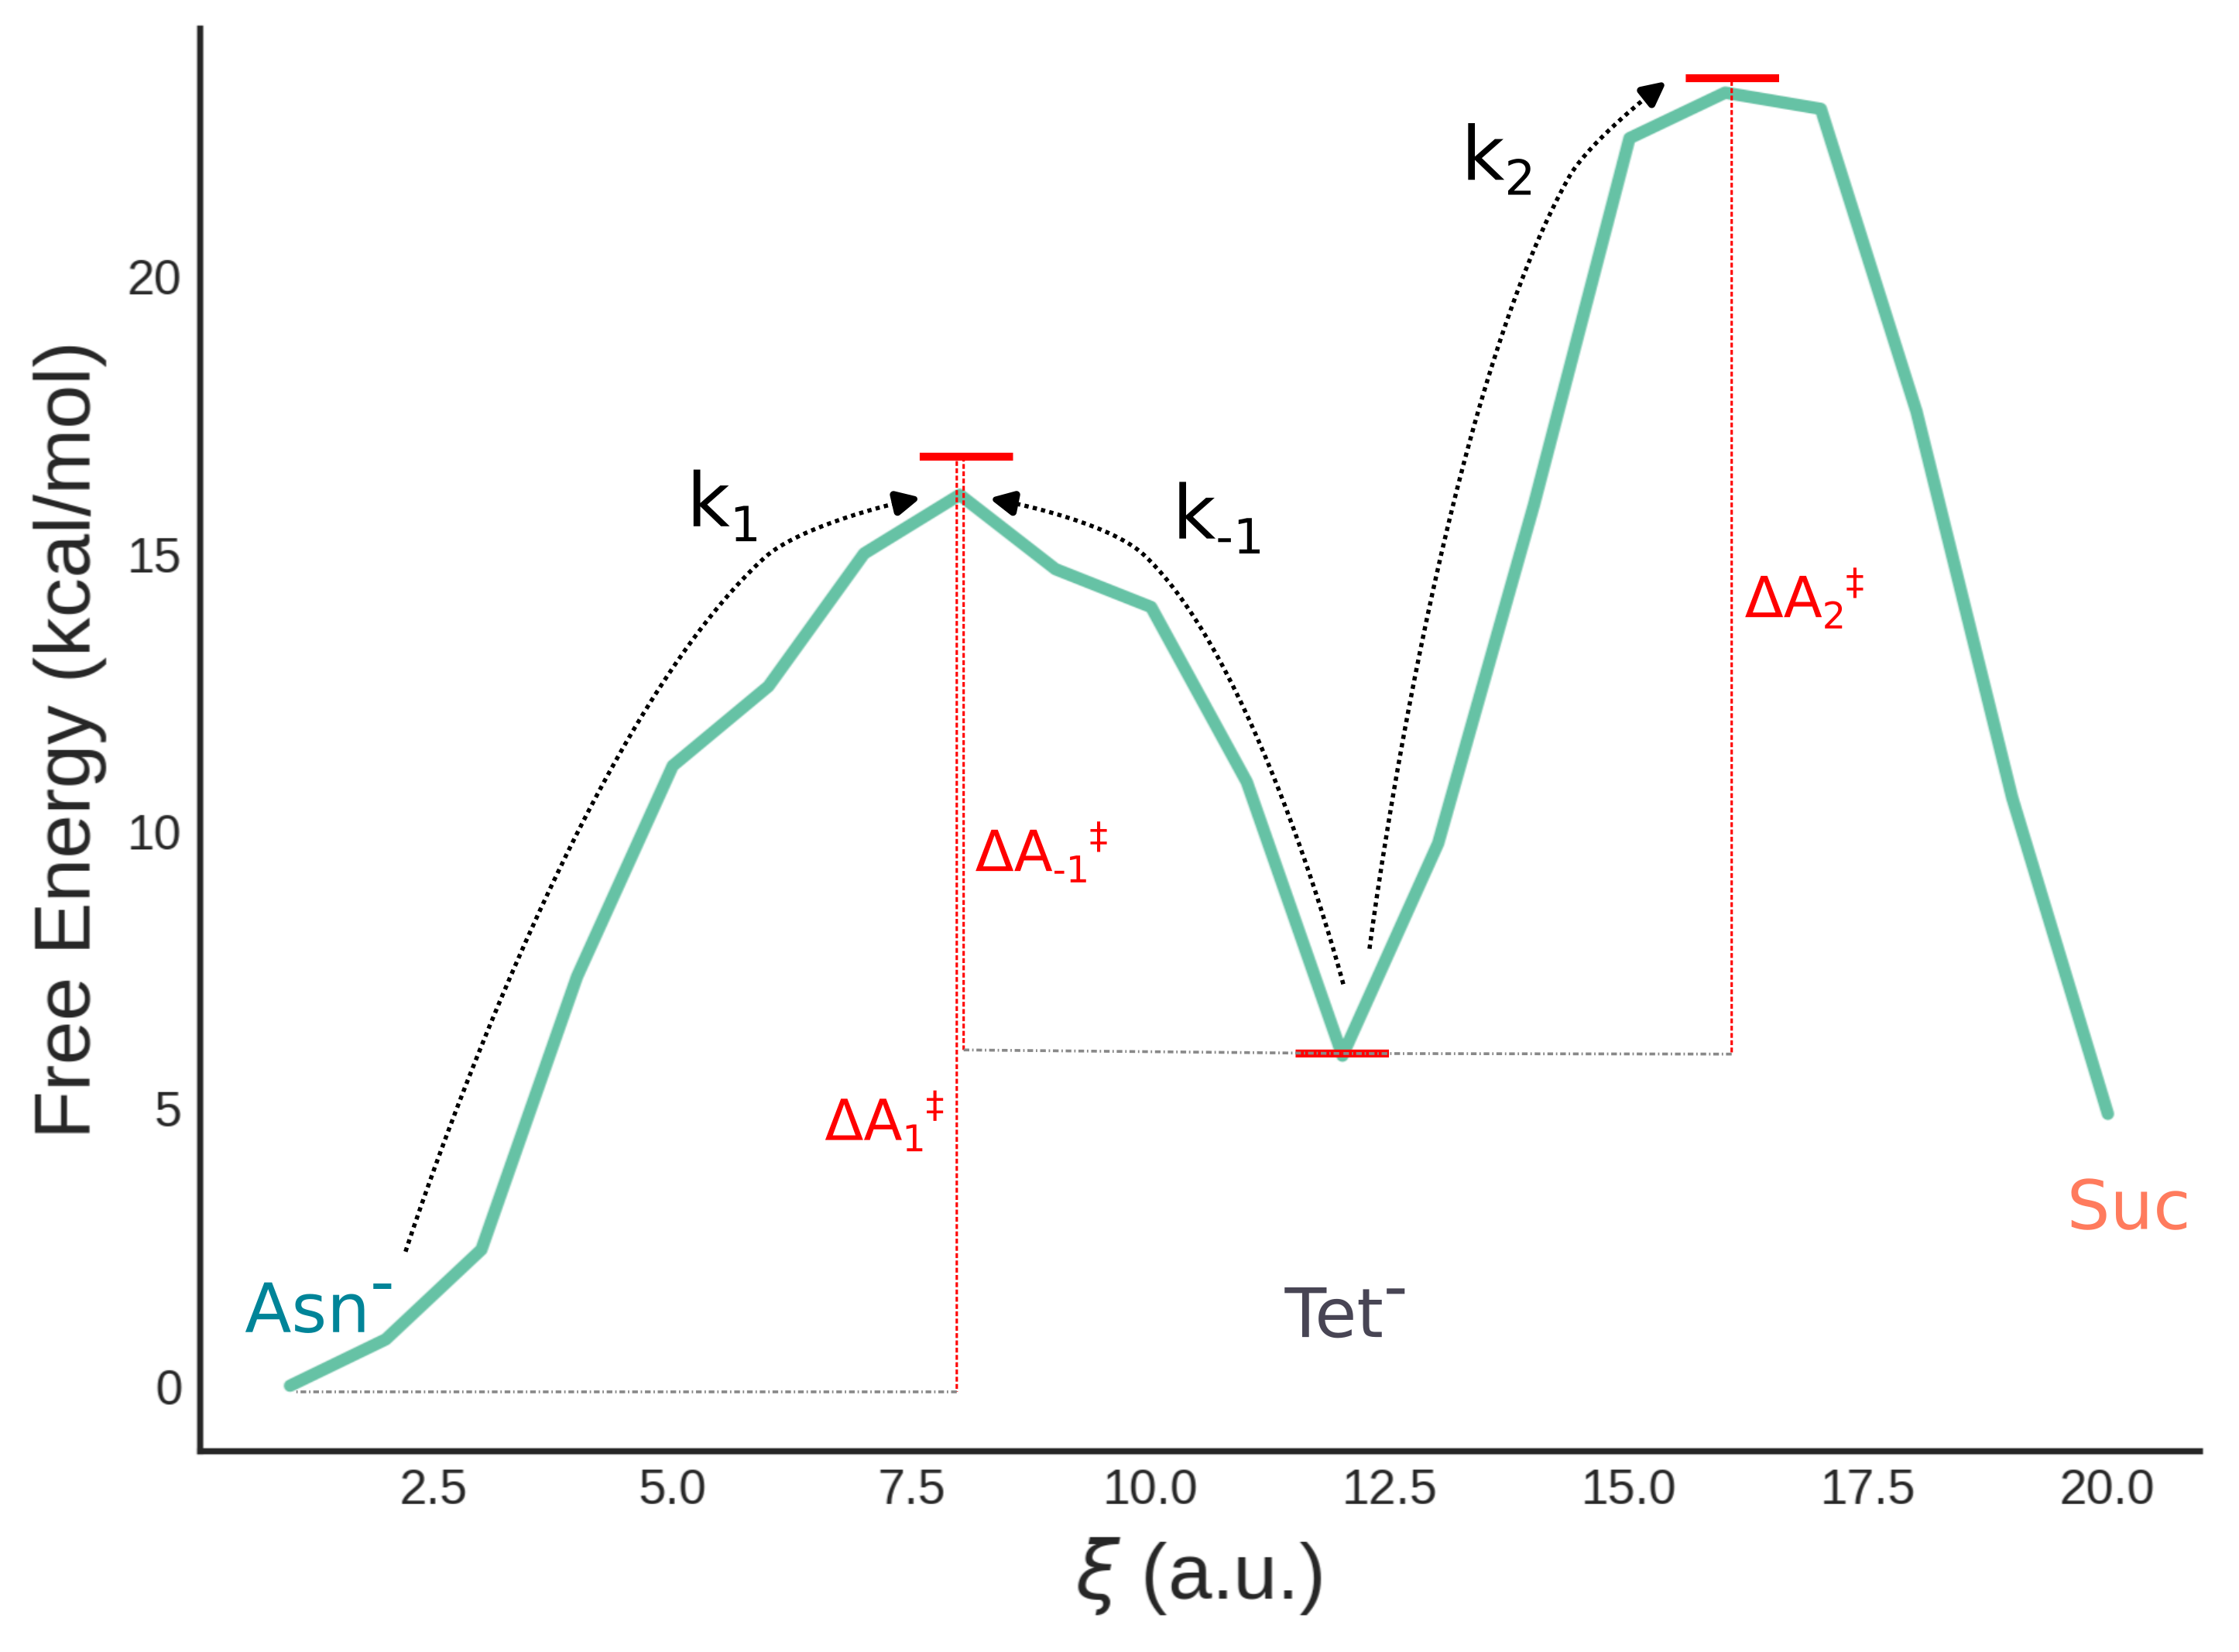

In [12]:
from IPython.display import Image
Image('pmm_math.png')